# Short Notebook 1

Use this notebook to reproduce the results of best prediction 1 (public score : )

#### Libraries and options

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import warnings

from sklearn.model_selection import cross_val_score,RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import time

%matplotlib inline
sns.set_style("ticks")

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

starting_directory_noe = 'C:/Users/NOE/source/repos/Energy-forecasting-NTNU/data/'
os.chdir(starting_directory_noe)

warnings.filterwarnings("ignore", category=FutureWarning)

RANDOM_SEED = 59

---

## Functions

This section contains all the functions that are used for further data analysis/processing


In [2]:
def read_data_location(location: str):
    """
    Description
    -----------
    Read data from Parquet files located in a specified directory.

    This function reads the training target, observed training data, estimated training data,
    and estimated test data from Parquet files located in the specified directory.
    
    Parameters
    ----------
    - `location` (str): The directory path where the Parquet files are located.

    Returns
    -------
    - A tuple containing the following DataFrames:
      - `train_target` (pandas.DataFrame): Training target data.
      - `X_train_observed` (pandas.DataFrame): Observed training data.
      - `X_train_estimated` (pandas.DataFrame): Estimated training data.
      - `X_test_estimated` (pandas.DataFrame): Estimated test data.

    Example
    -------
    ```python
    data_location = '/path/to/data_directory'
    train_target, X_train_observed, X_train_estimated, X_test_estimated = read_data_location(data_location)
    ```
    """
    train_target = pd.read_parquet(location+'/train_targets.parquet')
    X_train_observed = pd.read_parquet(location+'/X_train_observed.parquet')
    X_train_estimated = pd.read_parquet(location+'/X_train_estimated.parquet')
    X_test_estimated = pd.read_parquet(location+'/X_test_estimated.parquet')
    return(train_target, X_train_observed, X_train_estimated, X_test_estimated)



def find_low_correlation_columns(dataframe, threshold, verbose = True):
    """
    Description
    -----------
    Find and remove columns in a DataFrame with low absolute correlation coefficients.

    This function calculates the pairwise correlation coefficients between columns in a DataFrame and
    removes columns that have absolute correlation coefficients equal to or above the specified threshold.
    It provides the option to print the removed columns for reference.

    Parameters
    ----------
    - `dataframe` (pandas.DataFrame): The DataFrame for which low correlation columns should be found.
    - `threshold` (float): The threshold for absolute correlation coefficients. Columns with absolute
                      correlation coefficients greater than or equal to this threshold will be removed.
    - `verbose` (bool, optional): If True, print information about removed columns. Default is True.

    Returns
    -------
    - List of column names that remain in the DataFrame after removing low correlation columns.

    Example
    -------
    ```python
    import pandas as pd

    data = {'feature1': [1, 2, 3, 4, 5],
            'feature2': [2, 3, 4, 5, 6],
            'feature3': [5, 6, 7, 8, 9]}

    df = pd.DataFrame(data)
    threshold = 0.7

    selected_columns = find_low_correlation_columns(df, threshold)
    ```
    """
    
    correlation_matrix = dataframe[:].corr()

    feature_list = list(correlation_matrix.columns)
    removed_list = []
    for reference_index in range(len(feature_list)):
        reference_feature = feature_list[reference_index]

        # Check if this feature has not already been removed
        if reference_feature not in removed_list:
            for compared_index in range(reference_index+1,len(feature_list)):
                compared_feature = feature_list[compared_index]

                # Check if this feature has not already been removed
                if compared_feature not in removed_list:

                    # Get correlation coefficient
                    coefficient = correlation_matrix.loc[reference_feature,compared_feature]

                    # Remove column if it's a NaN
                    if pd.isna(coefficient):
                        removed_list.append(compared_feature)
                        if verbose : print(f"Removed {compared_feature} because it is NaN")
                        
                    # Remove if it is above threshold
                    if np.abs(coefficient)>=threshold:
                        removed_list.append(compared_feature)
                        if verbose : print(f"Removed \t{compared_feature}\tbecause it is correlated to\t{reference_feature}")
    
    
    output_list = feature_list.copy()
    for element in removed_list:
        output_list.remove(element)
        
    return list(output_list)





def fill_nan(Dataframe: pd.DataFrame, feature: str, verbose: bool = True):
    """
    Description
    -----------
    Fill missing (`NaN`) values in a specified feature of a DataFrame using forward-fill or backward-fill.

    This function checks for missing values in the specified feature and fills them using forward-fill (`ffill`)
    or backward-fill (`bfill`) if necessary. It also provides information about the filled method and missing data.

    Parameters
    ----------
    - `Dataframe` (pandas.DataFrame): The DataFrame containing the feature with missing values.
    - `feature` (str): The name of the feature in the DataFrame.
    - `verbose` (bool): whether to display information about the column being filled and the method used

    Returns
    -------
    - None, but it updates the input DataFrame in place by filling missing values.

    Example
    -------
    ```python
    import pandas as pd

    data = {'date': pd.date_range(start='2023-01-01', periods=100, freq='D'),
            'value': [1, 2, np.nan, 4, np.nan, 6, 7, 8, np.nan, 10]}

    df = pd.DataFrame(data)
    feature = 'value'

    fill_nan(df, feature)
    ```
    """
    it_na = np.where(Dataframe[feature].isna())[0]
    
    #If missing value
    if len(it_na != 0):
        if verbose:
            print("Missing data in",feature," size ",it_na.size," out of", Dataframe.shape[0])
        new_column = Dataframe[feature].ffill()
        method = 'ffill'
        
        if((np.any(new_column.isna()) == True)): 
            method = 'bfill'
            new_column = Dataframe[feature].bfill()
    
        if (np.any(new_column.isna()) == False):
            if verbose:
                print("Filled with",method,"method")
            Dataframe[feature] = new_column
        else:
            if verbose:
                print("WARNING : still NaN values in "+feature)

def load_clean_datasets(location: str, threshold: float,verbose=True):
    """
    Description
    -----------
    Load and preprocess datasets, handling missing values and highly correlated features.

    This function loads four datasets from the specified location and processes them. It replaces colons in column names,
    identifies low-correlation features, and fills missing values using the `fill_nan` function.

    Parameters
    ----------
    - `location` (str): The path or URL to the data files.
    - `threshold` (float): The threshold for feature correlation identification.
    - `verbose` (bool): whether to display information about the dataset being processed

    Returns
    -------
    - Tuple of DataFrames: A tuple containing four DataFrames for train_target, X_train_observed, X_train_estimated, and X_test_estimated.
    - List of Lists of str: A list of lists containing the names of low-correlation features for each DataFrame.

    Example
    -------
    ```python
    train_target, X_train_observed, X_train_estimated, X_test_estimated, FEATURES = load_clean_datasets("data/location", 0.7)
    ```
    """
    train_target, X_train_observed, X_train_estimated, X_test_estimated = read_data_location(location = location)


    # Process NaNs and highly correlated features
    dataframes = [train_target,X_train_observed,X_train_estimated,X_test_estimated]
    dataframe_names = ["train_target","X_train_observed","X_train_estimated","X_test_estimated"]
    index = 0
    FEATURES = [] # Contains the list of useful features for each dataframe


    for dataframe in dataframes:
        if verbose:
            print("** WORKING ON "+dataframe_names[index]+"**")
        # Replace colons with underscores in column names of 'dataframe'
        dataframe.columns = dataframe.columns.str.replace(':', '_')
        # Find low find_low_correlation_columns
        features = find_low_correlation_columns(dataframe,threshold,verbose=False)
        FEATURES.append(features)
        # Fill NaN
        for feature in dataframe.columns:
            fill_nan(dataframe,feature,verbose=False)
        index+=1
    return (train_target, X_train_observed, X_train_estimated, X_test_estimated,FEATURES)

def select_and_resample(Xdf: pd.DataFrame,Ydf: pd.DataFrame):
    """
    Description
    -----------
    Select and resample time series data.

    This function selects data from two time series dataframes, `Xdf` and `Ydf`, where there is a match in time values.
    It then resamples `Ydf` to a 15-minute interval using linear interpolation and returns the resulting time-aligned data.
    The output data contains only streaks of minutes `[15, 30, 45, 00]`.

    Parameters
    ----------
    - `Xdf` (pandas.DataFrame): The first time series dataframe containing `'date_forecast'` column.
    - `Ydf` (pandas.DataFrame): The second time series dataframe containing `'time'` column.

    Returns
    -------
    - Tuple of two pandas DataFrames:
      - The selected and filtered X values, with a 15-minute interval.
      - The resampled Y values, matching the selected X values.

    Example
    -------
    ```python
    Xdf = pd.DataFrame({'date_forecast': pd.date_range(start='2023-01-01', periods=100, freq='15T')})
    Ydf = pd.DataFrame({'time': pd.date_range start='2023-01-01', periods=200, freq='30T')})
    selected_X, selected_Y = select_and_resample(Xdf, Ydf)
    ```
    """
    
    ##### Select Y values where there are X values :
    Y_in_X_times = Ydf['time'].isin(Xdf['date_forecast'])
    Selected_Y = Ydf[Y_in_X_times].reset_index(drop=True)
    
    ##### Select X values where there are Y values
    # ceil the date forecast to the hour in Xdf
    Xdf['hourly_forecast'] = Xdf['date_forecast'].dt.ceil('H')
    X_in_Y_times = Xdf['hourly_forecast'].isin(Selected_Y['time'])
    Selected_X = Xdf[X_in_Y_times].reset_index(drop=True).drop(columns=['hourly_forecast'])

    #### Filter X values to get 4 consecutive 15 minutes
    valid_minutes = [15, 30, 45, 0]
    # Calculate the difference in minutes between consecutive rows
    Selected_X = Selected_X.sort_values('date_forecast')
    Selected_X['minute_diff'] = Selected_X['date_forecast'].diff().dt.total_seconds() / 60
    # Create a mask to identify valid minutes
    valid_mask = Selected_X['minute_diff'].isin(valid_minutes)
    # Create a mask to identify the start of consecutive valid minute streaks
    streak_start_mask = valid_mask & (~valid_mask.shift(1, fill_value=False))
    # Create a mask to identify the end of consecutive valid minute streaks
    streak_end_mask = valid_mask & (~valid_mask.shift(-1, fill_value=False))
    # Merge the start and end masks to get the full streak mask
    consecutive_streak_mask = streak_start_mask | streak_end_mask
    # Extend the streaks to include isolated values
    consecutive_streak_mask = consecutive_streak_mask | consecutive_streak_mask.shift(1, fill_value=False) | consecutive_streak_mask.shift(-1, fill_value=False)
    # Repeatedly extend the streaks until no more can be extended
    while True:
        extended_streaks = consecutive_streak_mask | consecutive_streak_mask.shift(1, fill_value=False) | consecutive_streak_mask.shift(-1, fill_value=False)
        if extended_streaks.equals(consecutive_streak_mask):
            break
        consecutive_streak_mask = extended_streaks
    # Identify the cases where the streaks start with non-15 minutes
    non_15_start = valid_mask & (streak_start_mask | streak_end_mask)
    consecutive_streak_mask = consecutive_streak_mask | non_15_start

    Selected_X_filtered = Selected_X[consecutive_streak_mask].drop(columns='minute_diff')

    #### Resample Ydf with 15 minute interval 
    Selected_Y.set_index('time', inplace=True)
    Selected_Y_resampled = Selected_Y.resample('15T').interpolate(method='linear') #  use 'nearest' for flatter interpolation
    Selected_Y_resampled = Selected_Y_resampled.reset_index()

    # Select Y resampled values where there are X values :
    Y_in_X_times_resampled = Selected_Y_resampled['time'].isin(Selected_X_filtered['date_forecast'])
    Selected_Y = Selected_Y_resampled[Y_in_X_times_resampled].reset_index(drop=True)
    # Again the other way round to remove data that passed through the filter
    Selected_X = Selected_X_filtered[Selected_X_filtered['date_forecast'].isin(Selected_Y['time'])].reset_index(drop=True)


    return(Selected_X[1:], Selected_Y[1:])  # remove first row which always starts with a 00

def remove_consecutive_identical_values(df: pd.DataFrame, feature: str):
    """
    Description
    -----------
    Remove rows with consecutive identical values in a specified feature of a DataFrame.

    Paramters
    ---------
    - `df` (pandas.DataFrame): The DataFrame to process.
    - `feature` (str): The name of the feature in the DataFrame.

    Returns
    -------
    - `pandas.DataFrame`: The filtered DataFrame with consecutive identical values removed.

    Example
    -------
    ```python
    import pandas as pd

    data = {'time': pd.date_range(start='2023-01-01', periods=100, freq='15T'),
            'value': [1, 2, 2, 3, 3, 3, 4, 4, 4, 4]}

    df = pd.DataFrame(data)
    feature = 'value'

    filtered_df = remove_consecutive_identical_values(df, feature)
    ```
    """
    # Identify rows with consecutive identical values in the specified feature
    mask = df[feature] != df[feature].shift(+1)

    # Filter and remove rows with consecutive identical values
    filtered_df = df[mask]

    return filtered_df


def select_o_clock(dataframe: pd.DataFrame, feature: str) -> pd.DataFrame:
    """
    Description
    -----------
    Select rows from a DataFrame where the time in the specified feature is a round hour (minute and second are 0) and sort them by the 'feature' column.

    Parameters
    ----------
    - `dataframe` (pandas.DataFrame): The DataFrame to process.
    - `feature` (str): The name of the feature column containing time values.

    Returns
    -------
    - `pandas.DataFrame`: The filtered DataFrame with rows where the time is a round hour, sorted by the 'feature' column.

    Example
    -------
    ```python
    import pandas as pd

    data = {'time_column': pd.date_range(start='2023-01-01', periods=100, freq='H')}

    df = pd.DataFrame(data)
    feature = 'time_column'

    filtered_df = select_o_clock(df, feature)
    ```
    """
     # Check if the feature column exists in the DataFrame
    if feature not in dataframe.columns:
        raise ValueError(f"'{feature}' column not found in the DataFrame")

    # Check if the feature column is of datetime type
    if not pd.api.types.is_datetime64_any_dtype(dataframe[feature]):
        raise ValueError(f"'{feature}' column should be of datetime type")

    # Filter the DataFrame to select rows with round-hour times
    filtered_df = dataframe[dataframe[feature].dt.minute == 0 & (dataframe[feature].dt.second == 0)]
    
    # Sort the filtered DataFrame by the 'feature' column
    filtered_df = filtered_df.sort_values(by=feature)

    return filtered_df


def lagged_features(df, time_intervals = [15,30,45],verbose=False):
    """
    Description
    -----------
    Generate lagged features in a DataFrame based on specified time intervals.

    This function creates lagged features for selected columns in the DataFrame by shifting the data back in time based on
    the provided time intervals. It then fills in missing values using the `fill_nan` function.

    Parameters
    ----------
    - `df` (pandas.DataFrame): The DataFrame to which lagged features will be added.
    - `time_intervals` (List[int]): List of time intervals (in minutes) for creating lagged features.
    - `verbose` (bool): Whether to display information about the lagged features being created.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with lagged features added and missing values filled.

    Example
    -------
    ```python
    data = {'date_forecast': pd.date_range(start='2023-01-01', periods=100, freq='H'),
            'value1': [1, 2, 3, 4, 5],
            'value2': [10, 20, 30, 40, 50]}

    df = pd.DataFrame(data)
    time_intervals = [15, 30, 45]

    lagged_df = lagged_features(df, time_intervals)
    ```
    """

    if time_intervals==0:
        return df
    
    new_df = df.copy()      
    new_columns = []

    for interval in time_intervals:
        # Create a suffix for the column names
        suffix = '__r' + str(interval)

        lagged_df = new_df.shift(interval//15).copy()

        for column in df.columns:
            if column not in ['date_forecast', 'date_calc','sin_year','cos_year']:
                lag_name=column + suffix
                if verbose: print(lag_name)
                # Add lagged column
                new_column = pd.DataFrame()
                new_column[lag_name] = new_df[column].copy()
                # Get the value at the shifted time
                mask = (new_df['date_forecast']-pd.to_timedelta(interval, unit='minutes') == lagged_df['date_forecast'])
                new_column.loc[mask,lag_name] = lagged_df.loc[mask,column]
                # Fix values where there is no data available
                new_column.loc[np.logical_not(mask),lag_name]=np.nan
                new_columns.append(new_column)

    new_df = pd.concat([new_df]+new_columns,axis=1)

    # Fill missing values with the last known value for each specific column
    for column in new_df.columns:
        fill_nan(new_df,column,verbose=False)
    
    return new_df


def normalize_dataframe_minmax_TEST(train_df: pd.DataFrame,test_df: pd.DataFrame,verbose = False):

    normalized_train = train_df.copy()
    normalized_test = test_df.copy()
    # Define the range [0, 1]
    min_range = 0
    max_range = 1
    
    # Iterate over each column and apply min-max scaling, excluding datetime columns
    for column in train_df.columns:
        if verbose:
            print(column)
        if train_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype,'<M8[us]']:
            min_val = min(train_df[column].min(),test_df[column].min())
            max_val = max(train_df[column].max(),test_df[column].max())
            if verbose:
                print(f"min:{min_val:.2f}\tmax:{max_val:.2f}")
                print(f"different:{min_val!=max_val}")
            # Normalize the non-datetime column between -1 and 1
            if min_val!=max_val:
                normalized_train[column] = min_range + (max_range - min_range) * (normalized_train[column] - min_val) / (max_val - min_val)
                normalized_test[column] = min_range + (max_range - min_range) * (normalized_test[column] - min_val) / (max_val - min_val)
            else :
                normalized_train[column] = min_range + (max_range - min_range) * normalized_train[column]/max(max_val,1)
                normalized_test[column] = min_range + (max_range - min_range) * normalized_test[column]/max(max_val,1)

    return (normalized_train, normalized_test)

def normalize_dataframe_mean_std(df: pd.DataFrame,verbose = False):
    """
    Description
    -----------
    Normalize a DataFrame using mean and standard deviation scaling.

    This function performs mean and standard deviation scaling to normalize each column in the DataFrame using the
    mean and standard deviation values calculated from the same DataFrame.

    Parameters
    ----------
    - `df` (pandas.DataFrame): The DataFrame to be normalized.
    - `verbose` (bool): Whether to display information about the columns being normalized.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with columns normalized based on mean and standard deviation values.

    Example
    -------
    ```python
    import pandas as pd

    data = {'feature1': [1, 2, 3, 4, 5],
            'feature2': [10, 20, 30, 40, 50]}

    df = pd.DataFrame(data)

    normalized_df = normalize_dataframe_mean_std(df)
    ```
    """

    normalized_df = df.copy()

    # Iterate over each column and apply mean/std scaling, excluding datetime columns
    for column in normalized_df.columns:
        if verbose:
            print(column)
        if normalized_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype,'<M8[us]']:
            mean = normalized_df[column].mean()
            std = normalized_df[column].std()
            if verbose:
                print(f"mean:{mean:1f} \tstd:{std:.1f}")
            if std!=0:
                normalized_df[column] = (normalized_df[column] - mean) / std
            else :
                normalized_df[column] = (normalized_df[column] - mean) / 1

    return normalized_df

def normalize_dataframe_mean_std_TEST(train_df: pd.DataFrame,test_df: pd.DataFrame,verbose = False):
    """
    Description
    -----------
    Normalize a test DataFrame using mean and standard deviation scaling, based on statistics from a training DataFrame.

    This function performs mean and standard deviation scaling to normalize each column in the test DataFrame using the
    mean and standard deviation values from the corresponding columns in the training DataFrame.

    Parameters
    ----------
    - `train_df` (pandas.DataFrame): The training DataFrame used to calculate mean and standard deviation statistics.
    - `test_df` (pandas.DataFrame): The test DataFrame to be normalized.
    - `verbose` (bool): Whether to display information about the columns being normalized.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with columns in the test DataFrame normalized based on mean and standard deviation
    statistics from the training DataFrame.

    Example
    -------
    ```python
    import pandas as pd

    train_data = {'feature1': [1, 2, 3, 4, 5],
                 'feature2': [10, 20, 30, 40, 50]}
    
    test_data = {'feature1': [6, 7, 8, 9, 10],
                'feature2': [60, 70, 80, 90, 100]}
    
    train_df = pd.DataFrame(train_data)
    test_df = pd.DataFrame(test_data)
    
    normalized_test_df = normalize_dataframe_mean_std_TEST(train_df, test_df)
    ```
    """
    normalized_df = test_df.copy()

    # Iterate over each column and apply mean/std scaling, excluding datetime columns
    for column in normalized_df.columns:
        if verbose:
            print(column)
        if normalized_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype,'<M8[us]']:
            mean = train_df[column].mean()
            std = train_df[column].std()
            if verbose:
                print(f"mean:{mean:1f} \tstd:{std:.1f}")
            if std!=0:
                normalized_df[column] = (normalized_df[column] - mean) / std
            else :
                normalized_df[column] = (normalized_df[column] - mean) / 1

    return normalized_df


def convert_datetime(df: pd.DataFrame, time_feature: str):
    new_df = df.copy()

    # Convert the 'time_feature' column to datetime if it's not already
    new_df[time_feature] = pd.to_datetime(new_df[time_feature])

    # Calculate the number of seconds since midnight and subtract it from 86400 to make it -1 at midnight
    new_df['seconds_since_midnight'] = (new_df[time_feature] - new_df[time_feature].dt.normalize()).dt.total_seconds()

    # Calculate the sine of the day with -1 at midnight
    new_df['sin_day'] = np.sin(2 * np.pi * new_df['seconds_since_midnight']/86400- np.pi/2)

    # Calculate the sine of the year with -1 on January 1st
    new_df['sin_year'] = np.sin(2 * np.pi * (new_df[time_feature].dt.dayofyear - 1)/365 - np.pi/2)

    # Calculate the cosine of the year with -1 on January 1st
    new_df['cos_year'] = np.cos(2 * np.pi * (new_df[time_feature].dt.dayofyear - 1)/365 - np.pi/2)

    # Calculate the difference in seconds between 'time_feature' and 'date_calc'
    # new_df['forecast_interval'] = (new_df[time_feature] - new_df['date_calc']).dt.total_seconds().fillna(0)

    # Drop the temporary 'seconds_since_midnight' column if you don't need it
    new_df.drop('seconds_since_midnight', axis=1, inplace=True)

    return new_df

def full_data_loader(location,n_lagged_features=3,threshold=0.9,normalization = 'minmax',date_encoding=True,verbose=True):
    """
    Description
    -----------
    Load, preprocess, and prepare data for training and prediction including feature engineering, normalization, and resampling.

    This function reads datasets, selects usable data, adds date encoding features, lagged features, and normalizes the data.

    Parameters
    ----------
    - `location` (str): The path or URL to the data files.
    - `n_lagged_features` (int): The number of lagged features to add.
    - `threshold` (float): The threshold for feature correlation identification.
    - `normalization` (str): The type of data normalization ('minmax' or 'mean'), or 'none' for no normalization.
    - `date_encoding` (bool): Whether to add date encoding features.
    - `verbose` (bool): Whether to display progress and information.

    Returns
    -------
    - Tuple of DataFrames, Series, and List: A tuple containing X_Train, Y_Train, X_Test, and a list of selected features.

    Example
    -------
    ```python
    location = "data/location"
    n_lagged_features = 3
    threshold = 0.9
    normalization = 'minmax'
    date_encoding = True
    verbose = True

    X_Train, Y_Train, X_Test, selected_features = full_data_loader(
        location, n_lagged_features, threshold, normalization, date_encoding, verbose
    )
    ```
    """
    # Read datasets
    if verbose: print("Reading datasets")
    train_target, X_train_observed, X_train_estimated, X_test_estimated, FEATURES = load_clean_datasets(location, threshold,verbose=False)
    
    selected_features = FEATURES[-1][1:] # all low correlation features from X_test_estimated except date
    
    # Select usable data and resample training target
    if verbose: print("Selecting training data")
    Ydf = remove_consecutive_identical_values(train_target,'pv_measurement')
    Xdf = pd.concat([X_train_observed,X_train_estimated]).reset_index(drop=True)
    X_Train,Y_Train = select_and_resample(Xdf,Ydf)
    
    # Add features to encode the date information
    if date_encoding:
        if verbose: print("Encoding date information")
        X_Train = convert_datetime(X_Train,'date_forecast')
        X_Test = convert_datetime(X_test_estimated, 'date_forecast')
    else:
        X_Test = X_test_estimated
    
    # Add lagged features
    if n_lagged_features!=0:
        if verbose: print("Adding lag features")
        time_lags = [15*n for n in range(1,n_lagged_features+1)] # in minutes
        X_Train = lagged_features(X_Train,time_intervals=time_lags,verbose=False)
        X_Test = lagged_features(X_Test,time_intervals=time_lags,verbose=False)
        feature_list = selected_features
        suffix_list = ['']+[f"__r{lag}" for lag in time_lags]
        selected_features = [f+suffix for f in feature_list for suffix in suffix_list]

    if date_encoding:
        selected_features += ['sin_day','sin_year','cos_year']

    # Normalize datasets
    if normalization in ['minmax', 'mean']:
        if verbose:print("Normalizing with "+normalization)
        if normalization == 'minmax':
            # X_Train_normal = normalize_dataframe_minmax(X_Train)
            X_Train_normal,X_Test_normal = normalize_dataframe_minmax_TEST(X_Train,X_Test)
        if normalization == 'mean':
            X_Train_normal = normalize_dataframe_mean_std(X_Train)
            X_Test_normal = normalize_dataframe_mean_std_TEST(X_Train,X_Test)
        X_Train = X_Train_normal
        X_Test = X_Test_normal



    print("\nDone\n")
    return (X_Train,Y_Train,X_Test,selected_features)

def hyperparameter_tune(base_model, parameters, n_iter, kfold, X, y):
    start_time = time.time()
    
    # Arrange data into folds with approx equal proportion of classes within each fold
    cv = KFold(n_splits=kfold,shuffle=True)
    
    optimal_model = RandomizedSearchCV(base_model,
                            param_distributions=parameters,
                            n_iter=n_iter,
                            cv=cv,
                            n_jobs=2,
                            random_state=RANDOM_SEED,
                            error_score='raise',
                            refit=True,
                            verbose=1)
    
    optimal_model.fit(X, y)
    
    stop_time = time.time()

    scores = cross_val_score(optimal_model, X, y, cv=cv, scoring="neg_mean_absolute_error",verbose=1)
    
    print("\nElapsed Time:", time.strftime("%H:%M:%S", time.gmtime(stop_time - start_time)))
    print("====================")
    print("Cross Val Mean: {:.3f}, Cross Val Stdev: {:.3f}".format(scores.mean(), scores.std()))
    print("Best Score: {:.3f}".format(optimal_model.best_score_))
    print("Best Parameters: {}".format(optimal_model.best_params_))
    
    return optimal_model.best_params_, optimal_model.best_score_

---
## Full data loader
This is a single function that performs all the data pre-processing

In [3]:
# Load all usable data 

LOCATION = "A"
n_lagged_features = 2
threshold = 0.95

X_Train_full,Y_Train_full,X_Test_full,selected_features = full_data_loader(location = LOCATION,
                                                        n_lagged_features=n_lagged_features,
                                                        threshold=threshold,
                                                        normalization = 'minmax',
                                                        date_encoding=True,
                                                        verbose=True)
print(f"{len(selected_features)} features selected\n")

# Select the correct columns for the prediction
X_Train = X_Train_full[selected_features].astype('float32')
X_Test = X_Test_full[selected_features].astype('float32')
Y_Train = Y_Train_full['pv_measurement'].astype('float32')

# Note : the lagged features code is a bit too extreme, a lot of 'unnecessary' lagged features -> increased complexity

print(f"{X_Train.shape[0]} points in the training dataset")

Reading datasets
Selecting training data
Encoding date information
Adding lag features
Normalizing with minmax

Done

84 features selected

77828 points in the training dataset


---
## Train models

Idk how to do cross validation help

In [4]:
# Split training data into train, validation and test 
from sklearn.model_selection import train_test_split

# Train/Test
X_train, X_test, Y_train, Y_test = train_test_split(X_Train,Y_Train,
                                                    test_size=0.1,
                                                    random_state=RANDOM_SEED,
                                                    shuffle=True)
# Train/Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train,
                                               test_size=0.1,
                                               random_state=RANDOM_SEED,
                                               shuffle=True)

### LGB regression

In [10]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

In [ ]:
# Convert data to LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=Y_train)

# Tune LightGBM hyperparameters
parameters = {
    "num_leaves": [500,600,800,1000,1100,1200],
    "learning_rate": [0.01,0.02,0.05,0.08,0.1],
    "num_iterations": [300,500,800,1000,1200,1500],
    "tree_learner": ['serial','voting'],
    "min_data_in_leaf": [10,50,100,500,1000]
}

base_model = lgb.LGBMRegressor(num_threads=2,objective='regression',metric='mse')
scores = []
folds = range(3, 6)
for i in folds:
    print("\ncv = ", i)
    best_params, best_score = hyperparameter_tune(base_model=base_model,
                                                parameters = parameters,
                                                n_iter=10,
                                                kfold=i,
                                                X=X_train,
                                                y=Y_train)
    scores.append(best_score)
    
plt.plot([x for x in folds], scores)
plt.xlabel("# of Folds")
plt.ylabel("Best Score")
plt.title("Impact of # of folds on Randomized Search CV score")
plt.show()

In [41]:
# train on the training dataset with optimal parameters


lgb_model = lgb.LGBMRegressor(tree_learner= 'serial',
                              num_threads= 2,
                              num_leaves= 500,
                              n_estimators= 1000,
                              metric= 'mse',
                              learning_rate= 0.08)
lgb_model.fit(X_train,Y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11324
[LightGBM] [Info] Number of data points in the train set: 63302, number of used features: 77
[LightGBM] [Info] Start training from score 1137.943310


LGBMRegressor(learning_rate=0.08, metric='mse', n_estimators=1000,
              num_leaves=500, num_threads=2, tree_learner='serial')

In [42]:
# Make predictions on observed data
X_test = X_test_obs
Y_test = Y_test_obs
Y_pred = np.asarray(lgb_model.predict(X_test,
                                      # num_iteration=lgb_model.best_iteration
                                      ))

# Evaluate the model
mae = mean_absolute_error(Y_test, Y_pred)
print(f"Mean Squared Error --observed-- : {mae:.0f}")

# Make predictions on estimated data (we can take the whole training dataset)
X_test = X_train_est
Y_test = Y_train_est
Y_pred = np.asarray(lgb_model.predict(X_test,
                                      # num_iteration=lgb_model.best_iteration
                                      ))

# Evaluate the model
mae = mean_absolute_error(Y_test, Y_pred)
print(f"Mean Squared Error --estimated-- : {mae:.0f}")

Mean Squared Error --observed-- : 103
Mean Squared Error --estimated-- : 287


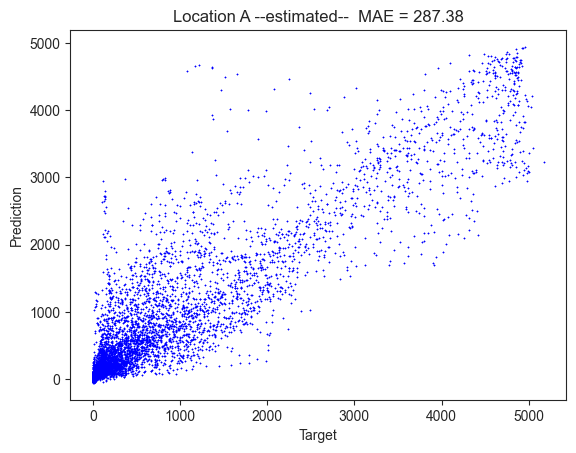

In [43]:
plt.figure()
plt.scatter(Y_test,Y_pred,s=0.05,c="b",marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"Location {LOCATION} --estimated--  MAE = {mae:.2f}")
plt.show()

### CatBoost regression

In [5]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

from catboost.utils import get_gpu_device_count
print('Detected GPU devices : %i' % get_gpu_device_count())

Detected GPU devices : 1


Using a randomized search for the hyper parameters of the catboost regressor.

**WARNING : this is *VERY* long (~100+ minutes)** 

In [ ]:
catboost_model = CatBoostRegressor(thread_count=2,verbose=100,allow_writing_files=True)

grid = {'learning_rate': [0.15, 0.20, 0.25, 0.30, 0.35],
        'depth': [8, 9, 10, 11, 12],
        'l2_leaf_reg': [7, 8, 9, 10,12,15,17,20,22,25]}

randomized_search_result = catboost_model.randomized_search(grid,
                                                   X=X_train,
                                                   y=Y_train,
                                                   plot=True,
                                                   cv=5,
                                                   verbose=True,
                                                   n_iter=10,
                                                   partition_random_seed=RANDOM_SEED)

Train the model

In [110]:
# {'bagging_temperature': 0, 'random_strength': 3, 'depth': 12, 'l2_leaf_reg': 6, 'learning_rate': 0.35}

# train on observed data
# X_train=X_train_obs
# Y_train=Y_train_obs


catboost_model = CatBoostRegressor(iterations=3000,
                          depth=8,
                          learning_rate=0.4,
                          min_data_in_leaf=8,
                          l2_leaf_reg=9,
                          loss_function='RMSE',
                          random_strength=1,
                          task_type='GPU',
                          devices= '0',
                          verbose=100,
                          allow_writing_files=False)


history = catboost_model.fit(X_train, Y_train,
                             eval_set = (X_val,Y_val),
                             early_stopping_rounds=50)

0:	learn: 954.1349435	test: 961.9096875	best: 961.9096875 (0)	total: 60.6ms	remaining: 3m 1s
100:	learn: 345.4751984	test: 377.6384306	best: 377.6384306 (100)	total: 2.84s	remaining: 1m 21s
200:	learn: 263.3676013	test: 318.7688092	best: 318.7688092 (200)	total: 4.93s	remaining: 1m 8s
300:	learn: 215.5943550	test: 283.3306787	best: 283.3306787 (300)	total: 6.86s	remaining: 1m 1s
400:	learn: 183.0401138	test: 261.6079200	best: 261.6079200 (400)	total: 8.88s	remaining: 57.6s
500:	learn: 160.0021256	test: 246.6971095	best: 246.6971095 (500)	total: 10.8s	remaining: 54s
600:	learn: 142.0996362	test: 233.9061129	best: 233.9061129 (600)	total: 12.7s	remaining: 50.6s
700:	learn: 128.4634812	test: 224.5960256	best: 224.5960256 (700)	total: 14.4s	remaining: 47.4s
800:	learn: 117.5901943	test: 217.6596089	best: 217.6596089 (800)	total: 16.2s	remaining: 44.6s
900:	learn: 107.9132665	test: 211.6672810	best: 211.6672810 (900)	total: 18s	remaining: 41.9s
1000:	learn: 99.8987050	test: 206.9201862	best

Test the model

Location A MAE : 112.01


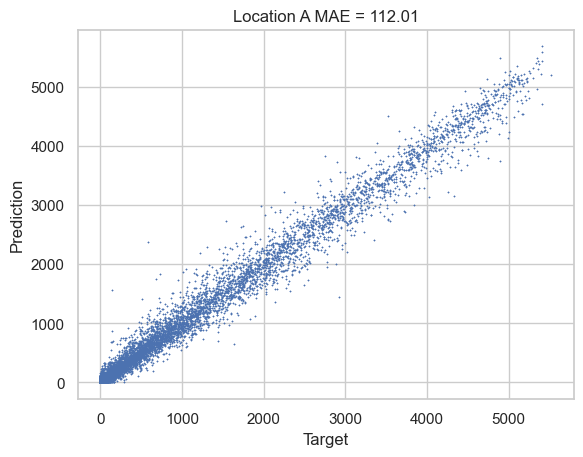

In [111]:
# catboost_model = CatBoostRegressor()
# X_test = X_test_obs
# Y_test = Y_test_obs

Y_pred = catboost_model.predict(X_test)
Y_pred[Y_pred<0]=0

mae = mean_absolute_error(Y_test, Y_pred)
# print(f"Location {LOCATION} --observed-- MAE : {mae:.2f}")
print(f"Location {LOCATION} MAE : {mae:.2f}")

# X_test = X_Train_est
# Y_test = Y_Train_est

# Y_pred = catboost_model.predict(X_test)
# Y_pred[Y_pred<0]=0

# mae = mean_absolute_error(Y_test, Y_pred)
# print(f"Location {LOCATION} --estimated-- MAE : {mae:.2f}")

plt.figure()
plt.scatter(Y_test,Y_pred,s=0.05,marker="*")
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"Location {LOCATION} MAE = {mae:.2f}")
plt.show()

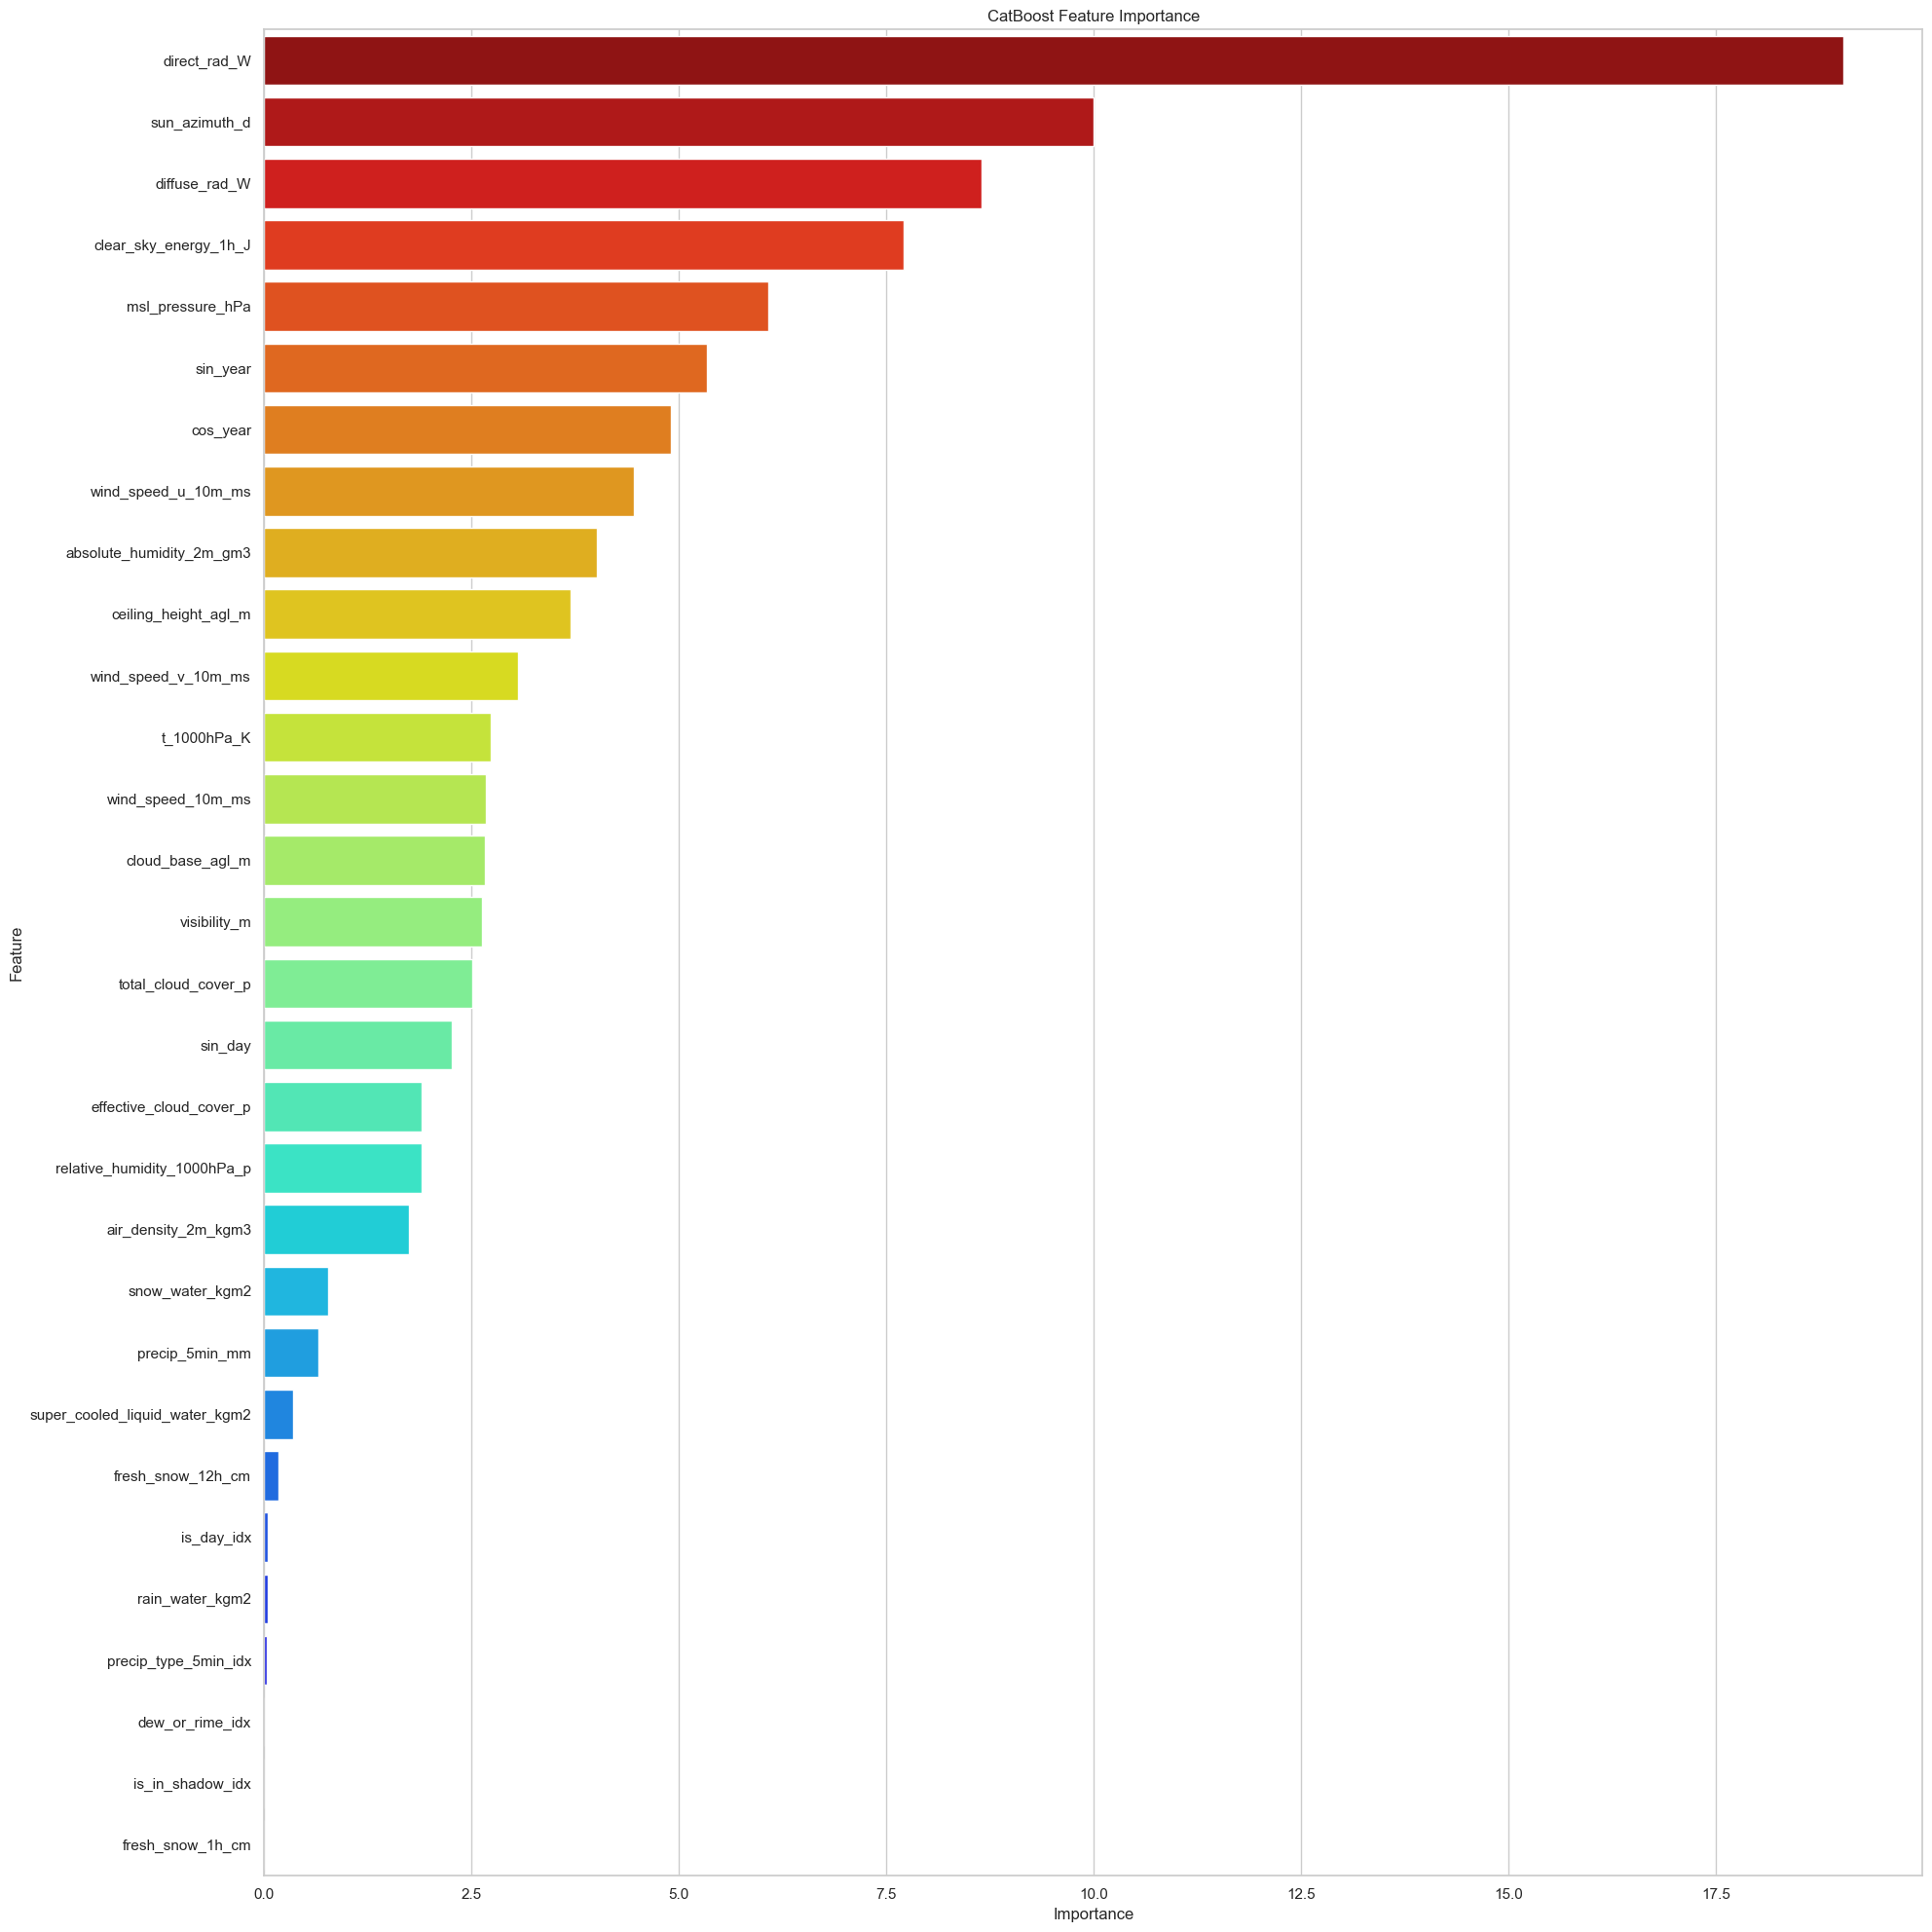

In [112]:
# catboost_model = model
feature_importances = catboost_model.get_feature_importance()
feature_names = X_Train.columns  # If your features are in a DataFrame

# Create a DataFrame to store feature names and their importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Set the style for the plot (optional)
sns.set(style="whitegrid")

# Create a barplot
plt.figure(figsize=(20, 20),dpi=100)
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="jet_r", hue='Feature',width=0.8,gap=2,dodge='auto')

# Customize the plot
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

# Show the plot
plt.show()

#### Backup information

##### Location A
`minmax, lag1, train_test_split=0.5`

Good candidates:

1. depth = 13, learning_rate=0.2, l2_leaf_reg=7
2. depth = 9, learning_rate=0.35, l2_leaf_reg=6

In [80]:
catboost_model.save_model("CatBoost_models/CatBoost"+LOCATION+"_lag2_observed_minmax.cbm",format='cbm')

In [16]:
# save model A

# training data :

catboostA = catboost_model
catboostA.save_model('CatBoost_models/CatBoostA_lag1_minmax_FULL_TRAIN.cbm',format='cbm')

In [12]:
# save model B

# training data :
"""
catboost_model = CatBoostRegressor(iterations=3000,
                          depth=11,
                          learning_rate=0.25,
                          l2_leaf_reg=7,
                          loss_function='RMSE',
                          task_type='GPU',
                          devices='0',
                          verbose=100)
"""

catboostB = catboost_model
catboostB.save_model('CatBoost_models/CatBoostB_lag1_minmax.cbm',format='cbm')

In [20]:
# save model C

# training data :
"""
catboost_model = CatBoostRegressor(iterations=3000,
                          depth=12,
                          learning_rate=0.20,
                          l2_leaf_reg=11,
                          loss_function='RMSE',
                          task_type='GPU',
                          devices='0',
                          verbose=100)
"""

catboostC = catboost_model
catboostC.save_model('CatBoost_models/CatBoostC_lag1_minmax.cbm',format='cbm')

We can try to train again using only the top 20 feature for example and see if it leads to better results

I did it and it was not convincing.

### XGBoost regression

In [113]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
import cupy as cp 

In [7]:
# Move the data to the GPU
X_train_gpu = cp.array(X_train)
Y_train_gpu = cp.array(Y_train)

Randomized search for XGB regression

In [ ]:
# A parameter grid for XGBoost
params = {
    'n_estimators':[500,600,700,1000],
    'min_child_weight':[5,10,15],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [4,6,7,8,9],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/20.0 for i in range(1,8)],
}

reg = XGBRegressor(nthread=2,device="cpu")

# run randomized search
n_iter_search = 10
random_search = hyperparameter_tune(base_model=reg,
                                    parameters=params,
                                    n_iter=n_iter_search,
                                    kfold=5,
                                    X=X_train,
                                    y=Y_train)


# random_search.fit(X_train, Y_train)

In [120]:
# {'subsample': 0.9, 'objective': 'reg:squarederror', 'n_estimators': 400, 'min_child_weight': 4, 'max_depth': 6, 'gamma': 0.5, 'eval_metric': 'rmse', 'eta': 0.3, 'colsample_bytree': 0.6, 'booster': 'gbtree'}
xgb_model = XGBRegressor(nthread=2,
                        device="cpu",
                        subsample=1,
                        objective ='reg:squarederror',
                        n_estimators = 1500,
                        min_child_weight=4,
                        max_depth=6,
                        eval_metric='rmse',
                        eta=0.3,
                        colsample_bytree=0.4,
                        booster='gbtree'
                        )

xgb_model.fit(X_train,
              Y_train,
              # eval_set = (X_val,Y_val),
              verbose=1)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, device='cpu', early_stopping_rounds=None,
             enable_categorical=False, eta=0.3, eval_metric='rmse',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=4, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1500,
             n_jobs=None, nthread=2, ...)

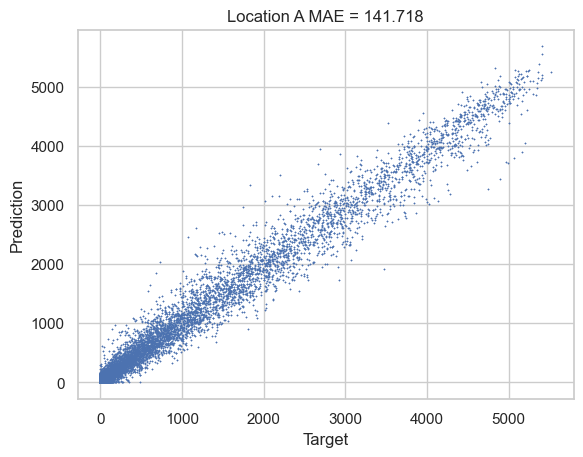

In [121]:
best_regressor = xgb_model

Y_pred = best_regressor.predict(X_test)
Y_pred[Y_pred<0]=0

mae = mean_absolute_error(Y_test, Y_pred)

plt.figure()
plt.scatter(Y_test,Y_pred,s=0.05,marker="*",)
#plt.scatter(Y_test_hour['pv_measurement'],Y_pred_hour['pv_measurement'],s=0.05,c="r",marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"Location {LOCATION} MAE = {mae:.3f}")
plt.show()

### MLP regression

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Dense,Input,Dropout
from sklearn.metrics import mean_absolute_error

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" # Comment this line to use GPU

In [6]:
# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # If GPUs are available, allow memory growth and select a GPU device
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(f"Physical GPUs: {len(gpus)}, Logical GPUs: {len(logical_gpus)}")
else:
    print("No GPU devices found. Using CPU.")

Physical GPUs: 1, Logical GPUs: 1


In [7]:
# Define hyperparameters and model architecture
input_shape = X_Train.shape[1]  # Shape of input data (number of features)
output_shape = 1                # Shape of output data (scalar)

In [8]:
# Define model architecure
def create_mlp(input_shape,output_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape)))
    model.add(Dense(input_shape, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))    # Input layer
    model.add(Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))            # Hidden layer
    model.add(Dense(512, activation='relu'))            # Hidden layer
    model.add(Dropout(0.2))                             # 20% dropout layer
    model.add(Dense(256, activation='relu'))            # Hidden layer
    model.add(Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))            # Hidden layer
    model.add(Dropout(0.2))                             # 20% dropout layer
    model.add(Dense(64, activation='relu'))             # Hidden layer
    model.add(Dropout(0.2))                             # 20% dropout layer
    model.add(Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))             # Hidden layer
    model.add(Dense(output_shape, activation='linear')) # Output layer
    
    # model.summary()
    return model

# Define a function to schedule the learning rate
def adaptive_learning_rate(epoch, lr):
    if epoch % 200 == 0 and epoch > 0:
        return lr / 2  # Divide the learning rate 
    else:
        return lr

In [9]:
# Cross validation
from sklearn.model_selection import TimeSeriesSplit, KFold

n_splits = 4
# K-folds
kf = KFold(n_splits=n_splits,shuffle=True,random_state=RANDOM_SEED)
# Time series split
tscv = TimeSeriesSplit(n_splits=n_splits)

In [10]:
# Training parameters
num_epochs = 200 
batch_size = 512  

fold_scores = []
learning_curves = []

# Perform cross-validation
for train_index, test_index in kf.split(X_Train):
    X_train_fold, X_val_fold = X_Train.iloc[train_index[:int(0.8*len(train_index))]], X_Train.iloc[train_index[int(0.8*len(train_index)):]]
    y_train_fold, y_val_fold = Y_Train.iloc[train_index[:int(0.8*len(train_index))]], Y_Train.iloc[train_index[int(0.8*len(train_index)):]]
    X_test_fold, y_test_fold = X_Train.iloc[test_index], Y_Train.iloc[test_index]

    # Create a new instance of your MLP model for each fold
    model = create_mlp(input_shape, output_shape)
    
    # Define the learning rate scheduler
    lr_scheduler = LearningRateScheduler(adaptive_learning_rate, verbose=1)
    

    # Compile and train the model for regression
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    
    history = model.fit(X_train_fold,
                        y_train_fold,
                        validation_data=(X_val_fold, y_val_fold),
                        validation_freq=10,
                        epochs=num_epochs, 
                        batch_size=batch_size,
                        verbose=2,
                        callbacks=[lr_scheduler])
    
    learning_curves.append(history)
    
    # Evaluate the model on the test data and calculate the regression score
    test_predictions = model.predict(X_test_fold)
    mae = mean_absolute_error(y_test_fold, test_predictions)
    fold_scores.append(mae)

# Calculate and report the average MSE (or other regression score) across all folds
average_mae = np.mean(fold_scores)
print(f"\n\nAverage MAE:{average_mae:.2f}")
print(fold_scores)

epoch_number=np.arange(0,num_epochs)
print(epoch_number)
val_number = epoch_number[::10]+9
print(val_number)

fig,ax=plt.subplots(nrows=1,ncols=n_splits,figsize=(20,5),dpi=150)
for index,history in enumerate(learning_curves):
    ax[index].plot(epoch_number,history.history['mean_absolute_error'])
    ax[index].plot(val_number,history.history['val_mean_absolute_error'])
    ax[index].set_title(f"Fold {index}\nMAE={fold_scores[index]:.0f}")
    ax[index].set_xlim([5,num_epochs])
    ax[index].set_ylim([np.min(history.history['mean_absolute_error'][5:]+history.history['val_mean_absolute_error'][1:])-20,
                        np.max(history.history['mean_absolute_error'][5:]+history.history['val_mean_absolute_error'][1:])+20])
fig.tight_layout()
plt.show()


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/200
92/92 - 4s - loss: 1397121.1250 - mean_absolute_error: 798.0779 - lr: 0.0010 - 4s/epoch - 39ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/200
92/92 - 1s - loss: 434237.6562 - mean_absolute_error: 421.6263 - lr: 0.0010 - 1s/epoch - 14ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/200
92/92 - 1s - loss: 394437.2188 - mean_absolute_error: 393.9363 - lr: 0.0010 - 1s/epoch - 13ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/200
92/92 - 1s - loss: 377366.8438 - mean_absolute_error: 382.7320 - lr: 0.0010 - 1s/epoch - 14ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/200
92/92 - 1s - loss: 369388.3125 - mean_absolute_error: 375.8152 - lr: 0.0010 - 1s/epoch - 15ms/step

Epoch 6: LearningRateScheduler setting lear

KeyboardInterrupt: 

Average MAE:327.09
[319.2965505696262, 314.1812191160568, 337.84693314664185, 337.0382992879098]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[ 9 19]


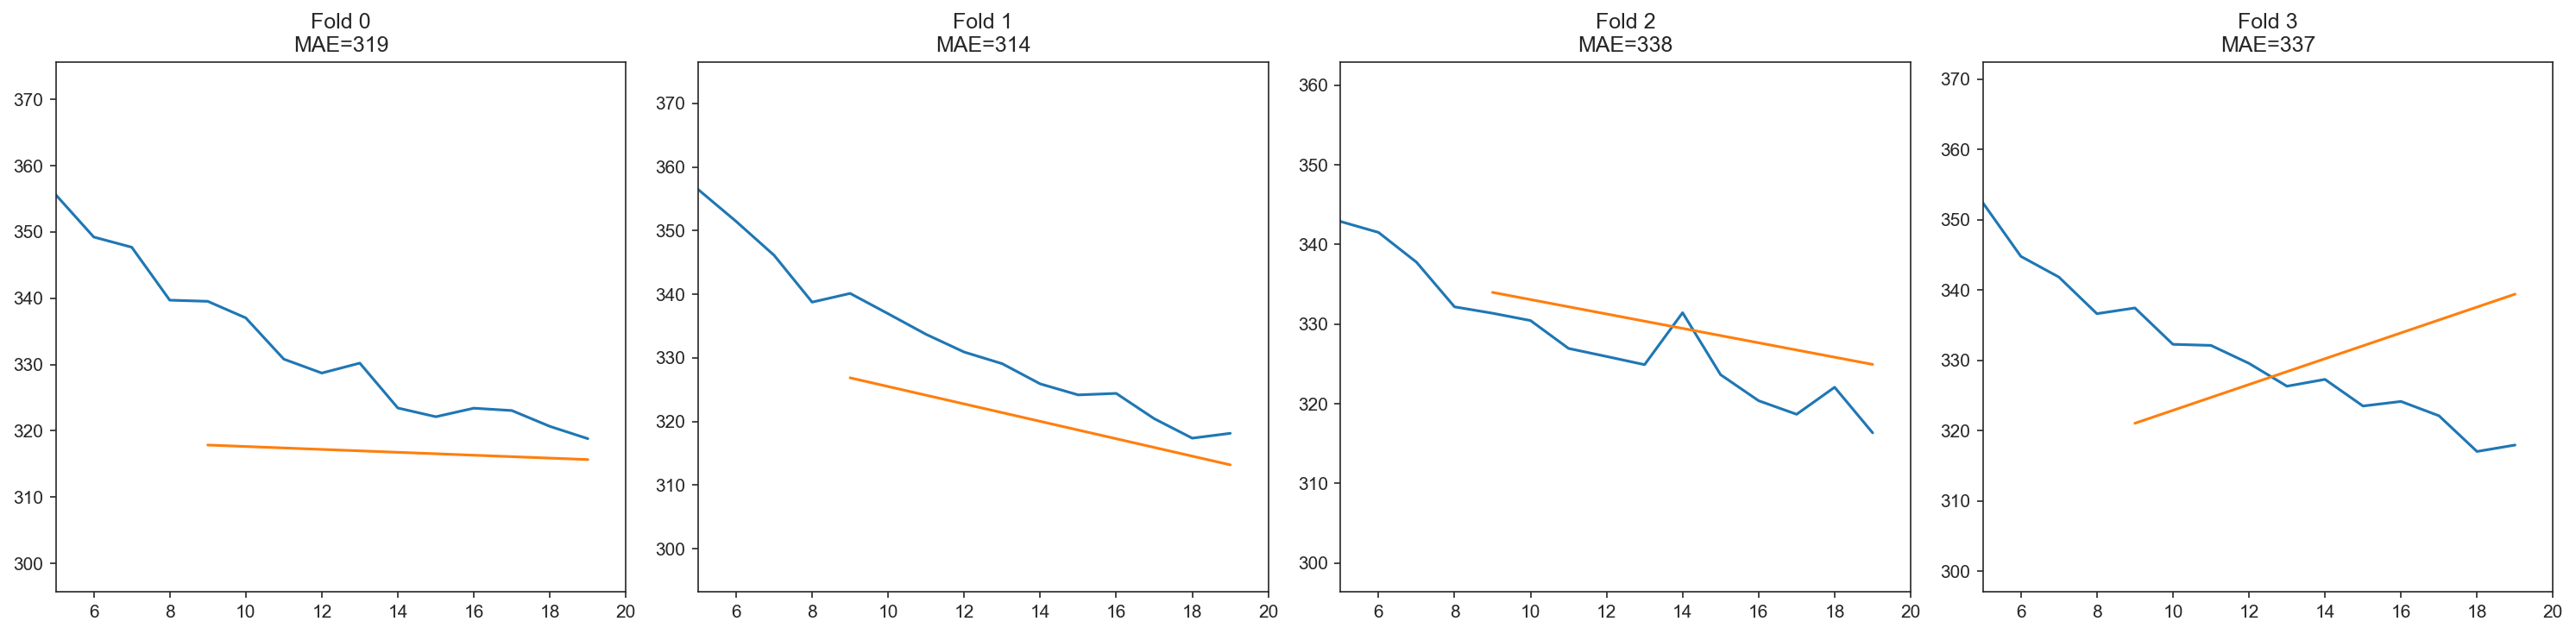

In [42]:
print(f"Average MAE:{average_mae:.2f}")
print(fold_scores)

epoch_number=np.arange(0,num_epochs)
print(epoch_number)
val_number = epoch_number[::10]+9
print(val_number)

fig,ax=plt.subplots(nrows=1,ncols=n_splits,figsize=(20,5),dpi=150)
for index,history in enumerate(learning_curves):
    ax[index].plot(epoch_number,history.history['mean_absolute_error'])
    ax[index].plot(val_number,history.history['val_mean_absolute_error'])
    ax[index].set_title(f"Fold {index}\nMAE={fold_scores[index]:.0f}")
    ax[index].set_xlim([5,num_epochs])
    ax[index].set_ylim([np.min(history.history['mean_absolute_error'][5:]+history.history['val_mean_absolute_error'][1:])-20,
                        np.max(history.history['mean_absolute_error'][5:]+history.history['val_mean_absolute_error'][1:])+20])
fig.tight_layout()
plt.show()

In [26]:
print(learning_curves[2].history['val_mean_absolute_error'])

[333.99090576171875, 324.9442138671875]


In [22]:
# Calculate and report the average MSE (or other regression score) across all folds
average_mae = np.mean(fold_scores)
print("Average MAE:", average_mae)
print(fold_scores)

# fig,ax=plt.subplots(nrows=1,ncols=n_splits)
# for index,history in enumerate(learning_curves):
#     ax[index].plot(history.history['mean_absolute_error'][1:])
#     ax[index].plot(history.history['val_mean_absolute_error'][1:])
#     ax[index].set_title(f"Fold {index}: MAE={fold_scores[index]}")
# fig.tight_layout()
# plt.show()

Average MAE: 431.1534876743867
[604.5325082240581, 389.09788074908624, 399.7617225362448, 377.51626420755576, 384.85906265498846]


In [12]:
# Training parameters
num_epochs = 300  
batch_size = 512  

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics = 'MeanAbsoluteError')

# Train the model
history = model.fit(X_train, Y_train, 
          epochs=num_epochs, 
          batch_size=batch_size,
          validation_data=(X_val,Y_val),
          verbose=2)

Epoch 1/300
124/124 - 4s - loss: 18675778.0000 - mean_absolute_error: 1141.3351 - val_loss: 710556.5000 - val_mean_absolute_error: 570.0073 - 4s/epoch - 30ms/step
Epoch 2/300
124/124 - 1s - loss: 764279.3750 - mean_absolute_error: 570.3568 - val_loss: 985940.0000 - val_mean_absolute_error: 628.0126 - 1s/epoch - 11ms/step
Epoch 3/300
124/124 - 1s - loss: 678936.5625 - mean_absolute_error: 541.3748 - val_loss: 1141895.6250 - val_mean_absolute_error: 695.6910 - 1s/epoch - 12ms/step
Epoch 4/300
124/124 - 1s - loss: 782865.5000 - mean_absolute_error: 574.0361 - val_loss: 535043.0000 - val_mean_absolute_error: 484.0460 - 1s/epoch - 11ms/step
Epoch 5/300
124/124 - 1s - loss: 657984.6250 - mean_absolute_error: 532.7234 - val_loss: 965770.4375 - val_mean_absolute_error: 649.3272 - 1s/epoch - 11ms/step
Epoch 6/300
124/124 - 1s - loss: 596783.5000 - mean_absolute_error: 507.9417 - val_loss: 496333.1875 - val_mean_absolute_error: 467.0674 - 1s/epoch - 11ms/step
Epoch 7/300
124/124 - 1s - loss: 556

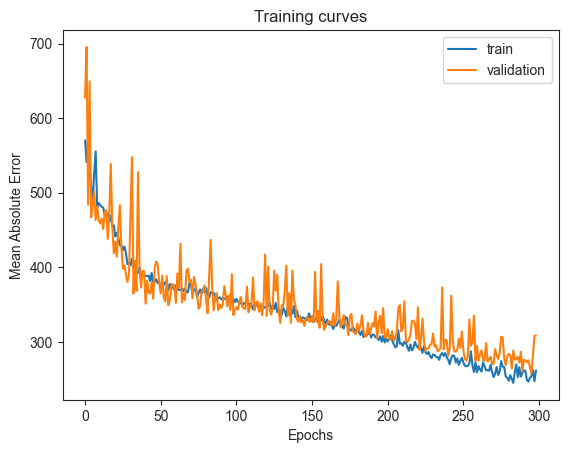

In [13]:
# plot history
plt.title("Training curves")
plt.plot(history.history['mean_absolute_error'][1:], label='train')
plt.plot(history.history['val_mean_absolute_error'][1:], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

244/244 [==============================] - 1s 5ms/step
MAE = 320


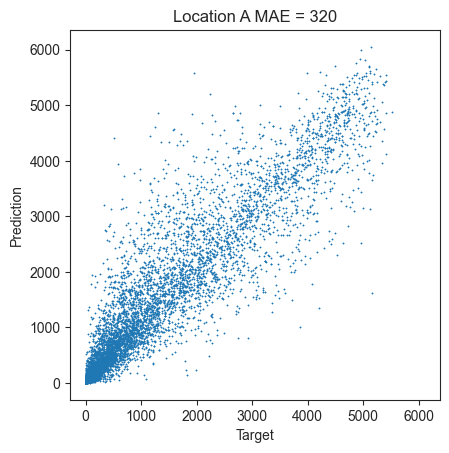

In [14]:
#model = MLP_model
# Make predictions every 15 minutes
Y_pred = model.predict(X_test.to_numpy())
#Y_pred = model.predict(X_test)
Y_pred[Y_pred<0]=0

mae = mean_absolute_error(Y_test, Y_pred)

print(f"MAE = {mae:.0f}")


plt.figure()
plt.scatter(Y_test,Y_pred,s=0.05,marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"Location {LOCATION} MAE = {mae:.0f}")
plt.axis("square")
plt.show()

In [17]:
# Save model

path = "./MLP_models/"+LOCATION+"_v4/"
model.save(path)

INFO:tensorflow:Assets written to: ./MLP_models/C_v4/assets


In [51]:
# Load model

path = "./MLP_models/"+LOCATION+"_v4/"
MLP_model = tf.keras.models.load_model(path)

### CNN regression
GPU is highly recommended (30s/epoch on CPU, 5s/epoch on GPU)

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from sklearn.metrics import mean_absolute_error

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" # comment this line to use GPU

In [10]:
# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # If GPUs are available, allow memory growth and select a GPU device
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(f"Physical GPUs: {len(gpus)}, Logical GPUs: {len(logical_gpus)}")
else:
    print("No GPU devices found. Using CPU.")

Physical GPUs: 1, Logical GPUs: 1


In [7]:
# Convert pandas dataframes to numpy arrays
X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy()
X_val = X_val.to_numpy()
Y_val = Y_val.to_numpy()
X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy()
# Check for NaN values
print(np.isnan(X_train).any())
print(np.isnan(Y_train).any())
print(np.isnan(X_val).any())
print(np.isnan(Y_val).any())
print(np.isnan(X_test).any())
print(np.isnan(Y_test).any())

False
False
False
False
False
False


In [8]:
# Reshape to 3D
n_features=X_train.shape[1]
X_train_backup=X_train
X_train = X_train.reshape((-1,n_features//11,11))
X_val = X_val.reshape((-1,n_features//11,11))
X_test = X_test.reshape((-1,n_features//11,11))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(63040, 20, 11)
(7005, 20, 11)
(7783, 20, 11)


In [9]:
# Define hyperparameters and model architecture
input_shape = (X_train.shape[1],X_train.shape[2],1) # Shape of input data
output_shape = 1                                    # Shape of output data (scalar)
print(input_shape)

(20, 11, 1)


In [11]:
# Define model architecure
model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=input_shape,padding="same"))
# model.add(MaxPooling2D(2,2))                        # MaxPooling
model.add(Conv2D(64,(3,3), activation='relu',padding="valid"))      # Convolution
model.add(MaxPooling2D(2,2))                        # MaxPooling
model.add(Conv2D(128,(3,3), activation='relu'))      # Convolution
#model.add(MaxPooling2D(2,2))
model.add(Flatten())                                # Flatten
# model.add(Dense(256, activation='relu'))             # Hidden layer
model.add(Dense(128, activation='relu'))             # Hidden layer
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))             # Hidden layer
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation='linear')) # Output layer

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 11, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 9, 64)         18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 4, 64)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 2, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 128)               229504    
                                                        

In [14]:
# Training parameters
num_epochs = 100  
batch_size = 256

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='mean_squared_error',
              metrics = 'MeanAbsoluteError')

# Train the model
history = model.fit(X_train, Y_train, 
          epochs=num_epochs, 
          batch_size=batch_size,
          validation_data=(X_val,Y_val),
          verbose=2)

# Save model
path = "./CNN_models/"+LOCATION+"_v5"
model.save(path)

# plot history
plt.title("Training curves")
plt.plot(history.history['mean_absolute_error'][1:], label='train')
plt.plot(history.history['val_mean_absolute_error'][1:], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

Epoch 1/100
247/247 - 7s - loss: 346989.6875 - mean_absolute_error: 350.2382 - val_loss: 204774.4062 - val_mean_absolute_error: 278.1853 - 7s/epoch - 28ms/step
Epoch 2/100
247/247 - 5s - loss: 343690.0938 - mean_absolute_error: 348.4296 - val_loss: 204582.6719 - val_mean_absolute_error: 273.7389 - 5s/epoch - 19ms/step
Epoch 3/100
247/247 - 4s - loss: 336283.9062 - mean_absolute_error: 345.2734 - val_loss: 203304.3594 - val_mean_absolute_error: 274.9739 - 4s/epoch - 18ms/step
Epoch 4/100
247/247 - 4s - loss: 342071.6250 - mean_absolute_error: 346.7361 - val_loss: 209260.0156 - val_mean_absolute_error: 281.3388 - 4s/epoch - 17ms/step
Epoch 5/100
247/247 - 4s - loss: 339021.6250 - mean_absolute_error: 345.7875 - val_loss: 204925.1719 - val_mean_absolute_error: 276.5803 - 4s/epoch - 17ms/step
Epoch 6/100
247/247 - 4s - loss: 334761.8125 - mean_absolute_error: 343.6305 - val_loss: 205873.8906 - val_mean_absolute_error: 277.2548 - 4s/epoch - 18ms/step
Epoch 7/100
247/247 - 4s - loss: 338592.

In [12]:
path = "./CNN_models/"+LOCATION+"_v4"
model = tf.keras.models.load_model(path)
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

244/244 [==============================] - 1s 5ms/step
MAE = 284


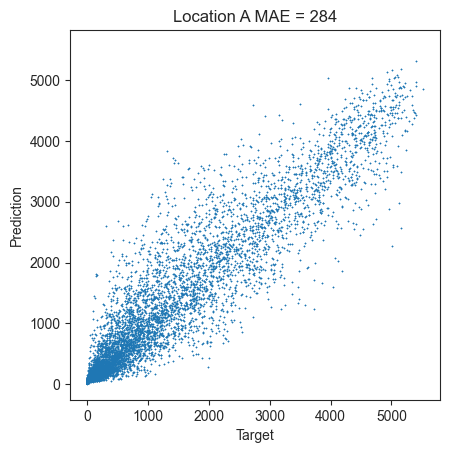

In [13]:
# Make predictions
Y_pred = model.predict(X_test)
#Y_pred = model.predict(X_test)
Y_pred[Y_pred<0]=0

mae = mean_absolute_error(Y_test, Y_pred)

print(f"MAE = {mae:.0f}")


plt.figure()
plt.scatter(Y_test,Y_pred,s=0.05,marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"Location {LOCATION} MAE = {mae:.0f}")
plt.axis("square")
plt.show()

### LSTM

In [5]:
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error

os.environ["CUDA_VISIBLE_DEVICES"]="-1" # comment this line to use GPU

In [25]:
def Sequential_Input_LSTM(df,target, input_sequence):
    df_np = df.to_numpy()
    target_np = target.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_np) - input_sequence):
        row = [a for a in df_np[i:i + input_sequence]]
        X.append(row)
        Y = target_np[i + input_sequence]
        y.append(Y)
        
    return np.array(X), np.array(y)


n_input = 10    # Number of rows used as input

X, y = Sequential_Input_LSTM(X_Train,Y_Train, n_input)

In [26]:
def create_lstm_model(n_input, n_features):
    model = Sequential()
    model.add(InputLayer((n_input,n_features)))
    print((n_input,n_features))
    model.add(LSTM(100, return_sequences = True))     
    model.add(LSTM(100, return_sequences = True))
    model.add(LSTM(50))
    model.add(Flatten())
    model.add(Dense(8, activation = 'relu'))
    model.add(Dense(1, activation = 'linear'))
    # model.summary()
    return model

In [27]:
n_splits=2
fold_scores = []

num_epochs=5
batch_size=64

tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(X):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Create a new instance of the LSTM model for each fold

    model1 = create_lstm_model(10,X_train_fold.shape[2])
    early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

    model1.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics=['mean_absolute_error'])

    model1.fit(X_train_fold, y_train_fold, 
            validation_data = (X_test_fold, y_test_fold), 
            epochs = num_epochs,
            batch_size=batch_size,
            callbacks = [early_stop])
    
    # Evaluate the model on the test data and calculate the regression score (e.g., MSE)
    test_predictions = model1.predict(X_test_fold)
    mae = mean_absolute_error(y_test_fold, test_predictions)
    fold_scores.append(mae)

average_mae = np.mean(fold_scores)
print("Average MAE:", average_mae)
print(fold_scores)

(10, 34)
Epoch 1/5
406/406 [==============================] - 26s 49ms/step - loss: 3022783.5000 - mean_absolute_error: 1122.6991 - val_loss: 2759485.5000 - val_mean_absolute_error: 1020.8489
Epoch 2/5
406/406 [==============================] - 20s 48ms/step - loss: 2656285.7500 - mean_absolute_error: 1045.7023 - val_loss: 2358026.5000 - val_mean_absolute_error: 962.0008
Epoch 3/5
406/406 [==============================] - 20s 49ms/step - loss: 2235843.2500 - mean_absolute_error: 1002.5322 - val_loss: 2021715.7500 - val_mean_absolute_error: 963.6328
Epoch 4/5
406/406 [==============================] - 20s 49ms/step - loss: 2657488.0000 - mean_absolute_error: 1095.9399 - val_loss: 3025452.5000 - val_mean_absolute_error: 1095.6337
Epoch 5/5
811/811 [==============================] - 10s 10ms/step
(10, 34)
Epoch 1/5
811/811 [==============================] - 43s 46ms/step - loss: 2929974.0000 - mean_absolute_error: 1082.4351 - val_loss: 2515559.0000 - val_mean_absolute_error: 966.9447
Epo

In [28]:
# Create a TimeSeriesSplit object with the desired number of splits
n_splits=1
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize a list to store the split indices
split_indices = []

# Split the data using Time Series Split
for train_index, val_index in tscv.split(X_Train):
    split_indices.append((train_index, val_index))

In [29]:
num_epochs = 2
batch_size = 64

fold_scores = []
learning_curves = []

# Time Series Cross validation
for train_index, val_index in split_indices:
    X_train_fold = X_Train.iloc[train_index].to_numpy()
    Y_train_fold = Y_Train.iloc[train_index].to_numpy()
    X_val_fold = X_Train.iloc[val_index].to_numpy()
    Y_val_fold = Y_Train.iloc[val_index].to_numpy()


    # Reshape the input data for the LSTM model
    input_shape = (X_train_fold.shape[1], 1)  # Assuming one feature per time step
    X_train_fold = X_train_fold.reshape((X_train_fold.shape[0], X_train_fold.shape[1], 1))
    X_val_fold = X_val_fold.reshape((X_val_fold.shape[0], X_val_fold.shape[1], 1))

    # Create and compile the LSTM model
    model = create_lstm_model(input_shape)

    # Train the model
    history = model.fit(X_train_fold,
                        Y_train_fold,
                        validation_data=(X_val_fold, Y_val_fold),
                        epochs=num_epochs,
                        batch_size=batch_size,
                        verbose=1)
    learning_curves.append(history)

    # Evaluate the model on the validation data
    Y_pred_fold = model.predict(X_val_fold)

    # Reshape Y_pred_fold and Y_val_fold to be 2D arrays
    # Y_pred_fold = Y_pred_fold.reshape((Y_pred_fold.shape[0], -1))
    # Y_val_fold = Y_val_fold.reshape((Y_val_fold.shape[0], -1))
    # print(Y_pred_fold.shape)
    # print(Y_val_fold.shape)

    mae = mean_absolute_error(Y_val_fold, Y_pred_fold)
    fold_scores.append(mae)
    print(f"Validation MAE: {mae}")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 34, 50)            10400     
                                                                 
 flatten (Flatten)           (None, 1700)              0         
                                                                 
 dense_9 (Dense)             (None, 10)                17010     
                                                                 
 dense_10 (Dense)            (None, 1)                 11        
                                                                 
Total params: 27,421
Trainable params: 27,421
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2
244/244 [==============================] - 10s 31ms/step - loss: 2361826.5000 - mean_absolute_error: 942.9780 - val_loss: 3365397.5000 - val_mean_absolute_error: 1228.1620
Epoch 2/2
487/487 [==============================] - 4s 7ms/step
(15565, 1)
(15565, 1)
Validation MAE: 1045.321304922133
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 34, 50)            10400     
                                                                 
 flatten_1 (Flatten)         (None, 1700)              0         
                                                                 
 dense_11 (Dense)            (None, 10)                17010     
                                                                 
 dense_12 (Dense)            (None, 1)                 11        
                                                                 
Total params: 

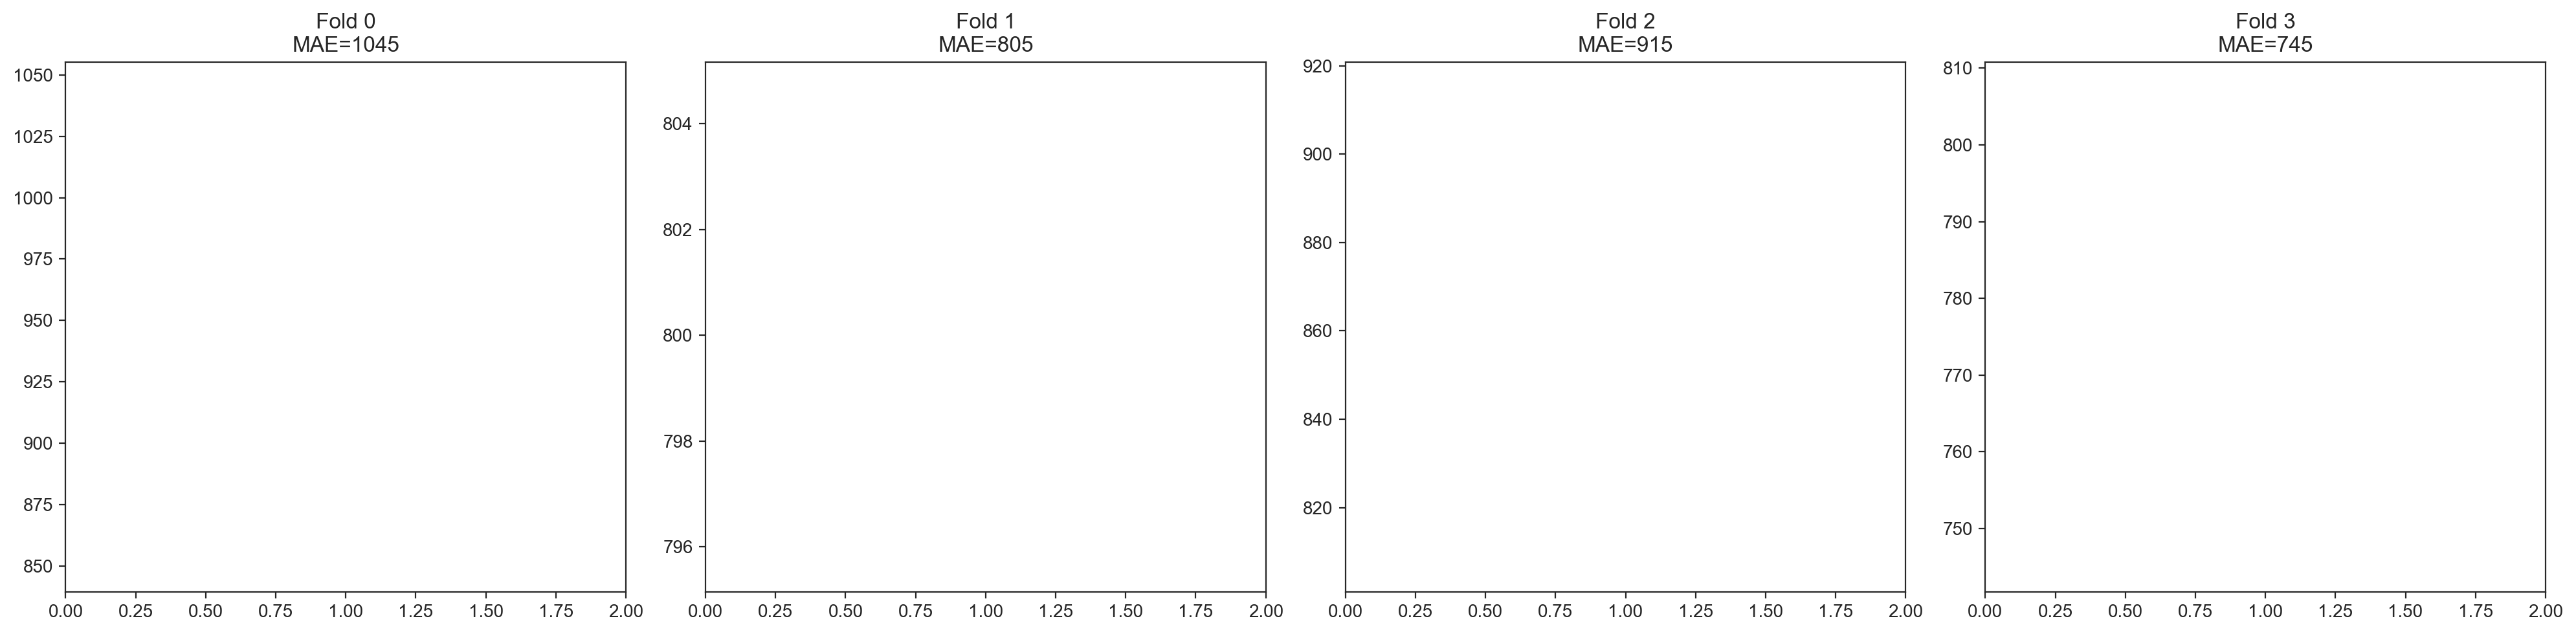

In [40]:
fig,ax=plt.subplots(nrows=1,ncols=n_splits,figsize=(20,5),dpi=200)
for index,history in enumerate(learning_curves):
    ax[index].plot(history.history['mean_absolute_error'][1:])
    ax[index].plot(history.history['val_mean_absolute_error'][1:])
    ax[index].set_title(f"Fold {index}\nMAE={fold_scores[index]:.0f}")
    ax[index].set_xlim([0,num_epochs])
fig.tight_layout()
plt.show()

In [33]:
learning_curves[0].history

{'loss': [2361826.5, 1603075.125],
 'mean_absolute_error': [942.97802734375, 849.3168334960938],
 'val_loss': [3365397.5, 1625919.875],
 'val_mean_absolute_error': [1228.1619873046875, 1045.3218994140625]}

335/335 [==============================] - 1s 3ms/step
MAE = 48


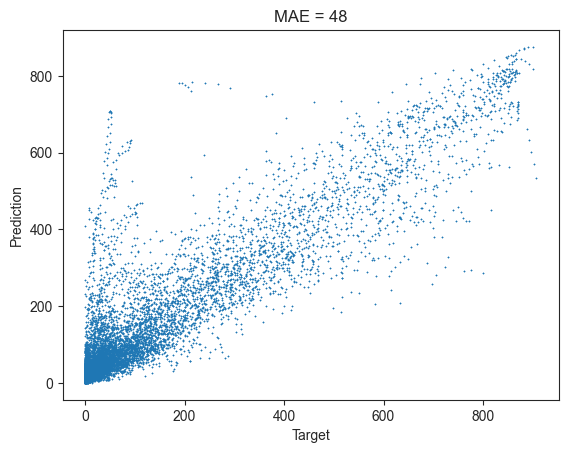

In [51]:
# Make predictions every 15 minutes
Y_pred = model.predict(test_X)
#Y_pred = model.predict(X_test)
Y_pred[Y_pred<0]=0

mae = mean_absolute_error(test_y, Y_pred)

print(f"MAE = {mae:.0f}")


plt.figure()
plt.scatter(test_y,Y_pred,s=0.05,marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"MAE = {mae:.0f}")
plt.show()

### K-Neighbors regression

In [122]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

In [129]:
# X_train = X_train_obs
# Y_train = Y_train_obs

model = KNeighborsRegressor(n_neighbors=2,
                      leaf_size=35,
                      algorithm='brute')
model.fit(X_train,Y_train)

KNeighborsRegressor(algorithm='brute', leaf_size=35, n_neighbors=2)

Location A --observed-- MAE : 63.93


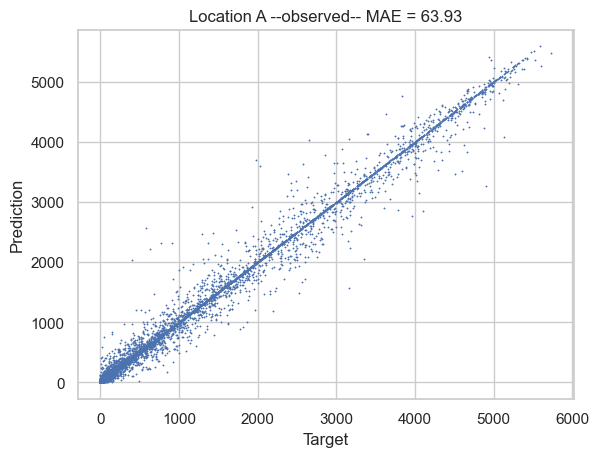

In [131]:
# X_test = X_test_obs
# Y_test = Y_test_obs

Y_pred = model.predict(X_val)
Y_pred[Y_pred<0]=0

mae = mean_absolute_error(Y_val, Y_pred)
print(f"Location {LOCATION} --observed-- MAE : {mae:.2f}")

plt.figure()
plt.scatter(Y_val,Y_pred,s=0.05,marker="*")
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"Location {LOCATION} --observed-- MAE = {mae:.2f}")
plt.show()

# X_test = X_Train_est
# Y_test = Y_Train_est

# Y_pred = model.predict(X_test)
# Y_pred[Y_pred<0]=0

# mae = mean_absolute_error(Y_test, Y_pred)
# print(f"Location {LOCATION} --estimated-- MAE : {mae:.2f}")

# plt.figure()
# plt.scatter(Y_test,Y_pred,s=0.05,marker="*")
# plt.xlabel("Target")
# plt.ylabel("Prediction")
# plt.title(f"Location {LOCATION} --estimated-- MAE = {mae:.2f}")
# plt.show()

In [83]:
from joblib import dump
dump(model,'KNeighbor_models/kneighbor_'+LOCATION+'_lag2_observed.joblib')

['KNeighbor_models/kneighbor_C_lag2_observed.joblib']

## Stacking models

I think the cross validation scores are bad because i don't know how to perform cross validation.
Here we will try to stack models to improve the prediction. The idea is the following, with `X_Test` the data that models at level 0 have not seen during training :

    X_Test -> [X_Test_train, X_Test_test]

                               level 0                                                          level 1
                    | model1 -> predictions 1 |     concatenate predictions with      |                           |
    X_Test_train -> | model2 -> predictions 2 | ->  X_Test_train, do feature       -> | model -> final prediction |
                    | model3 -> predictions 3 |     engineering and stuff             |                           |

For level 0 we will use CatBoost, MLP, K-neighbors and DecisionTree. The optimal parameters for each model are searched with RandomSearchCV. 
For level 1 we will use a LinearRegression model that takes as input the predictions of each model as well as the inputs

In [5]:
from sklearn.model_selection import cross_val_score,RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RepeatedKFold,KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import tensorflow as tf

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" # Comment this line to use GPU

### Decision Tree Regressor parameters search

In [43]:
base_model = DecisionTreeRegressor()

parameters = {
    "max_depth": [4,5,6,7,8,None],
    "min_samples_leaf": [1,2,3,4,5,6],
    "splitter": ['best','random'],
    "min_samples_split": [2,3,4]
}

scores = []
folds = range(2, 7)
for i in folds:
    print("\ncv = ", i)
    best_params, best_score = hyperparameter_tune(base_model=base_model,
                                                parameters = parameters,
                                                n_iter=10,
                                                kfold=i,
                                                X=X_train,
                                                y=Y_train)
    scores.append(best_score)
    
plt.plot([x for x in folds], scores)
plt.xlabel("# of Folds")
plt.ylabel("Best Score")
plt.title("The Impact of # of Folds on Randomized Search CV Score")
plt.show()


cv =  2
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fitting 2 folds for each of 10 candidates, totalling 20 fits

Elapsed Time: 00:00:11
Cross Val Mean: -387.832, Cross Val Stdev: 3.582
Best Score: 0.800
Best Parameters: {'splitter': 'random', 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': None}

cv =  3
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Elapsed Time: 00:00:12
Cross Val Mean: -321.640, Cross Val Stdev: 48.445
Best Score: 0.829
Best Parameters: {'splitter': 'random', 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': None}

cv =  4
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 1

In [57]:
#Best Parameters
tree_best_param = {'splitter': 'random', 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': None}

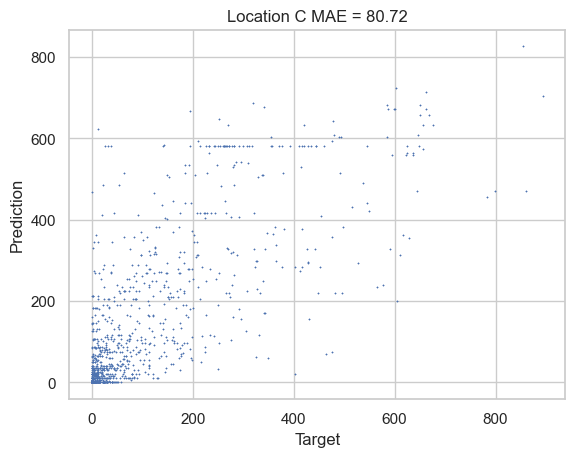

In [71]:
dectree_model = DecisionTreeRegressor(splitter='random',
                                      min_samples_split=3,
                                      min_samples_leaf=2,
                                      max_depth=None)
dectree_model.fit(X_train,Y_train)

Y_pred = dectree_model.predict(X_test)
Y_pred[Y_pred<0]=0

mae = mean_absolute_error(Y_test, Y_pred)

plt.figure()
plt.scatter(Y_test,Y_pred,s=0.05,marker="*")
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"Location {LOCATION} MAE = {mae:.2f}")
plt.show()

### K-Neighbors Regressor search


cv =  2
Fitting 2 folds for each of 10 candidates, totalling 20 fits


Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fitting 2 folds for each of 10 candidates, totalling 20 fits

Elapsed Time: 00:03:38
Cross Val Mean: -21.032, Cross Val Stdev: 0.085
Best Score: 0.973
Best Parameters: {'n_neighbors': 1, 'leaf_size': 35, 'algorithm': 'kd_tree'}

cv =  3
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Elapsed Time: 00:04:17
Cross Val Mean: -20.700, Cross Val Stdev: 0.135
Best Score: 0.986
Best Parameters: {'n_neighbors': 2, 'leaf_size': 35, 'algorithm': 'brute'}

cv =  4
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidate

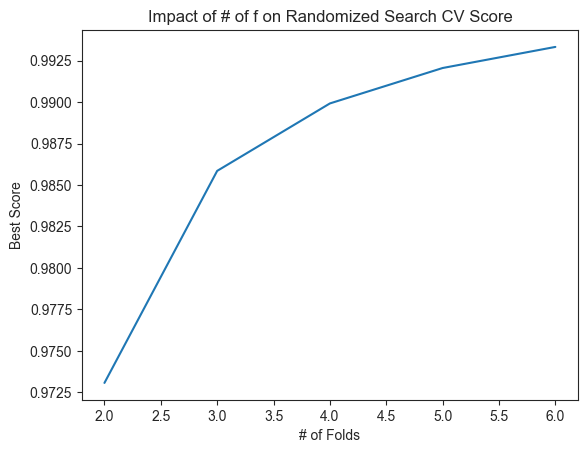

In [9]:
base_model = KNeighborsRegressor(n_jobs=2)

parameters = {
    "n_neighbors": [1,2,3,4,5,6,7,8,9,10,15,20,30],
    "leaf_size": [20,25,30,35,40],
    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
    # "p": [1,2,3]
}

scores = []
folds = range(2, 7)
for i in folds:
    print("\ncv = ", i)
    best_params, best_score = hyperparameter_tune(base_model=base_model,
                                                parameters = parameters,
                                                n_iter=10,
                                                kfold=i,
                                                X=X_train,
                                                y=Y_train)
    scores.append(best_score)
    
plt.plot([x for x in folds], scores)
plt.xlabel("# of Folds")
plt.ylabel("Best Score")
plt.title("Impact of # of f on Randomized Search CV Score")
plt.show()

In [ ]:
#Best Parameters
k_neighbor_best_param = {'n_neighbors': 2, 'leaf_size': 35}

### MLP Regressor parameters search

In [75]:
from sklearn.neural_network import MLPRegressor
base_model = MLPRegressor()

parameters = {
    "hidden_layer_sizes": [[128,128],[32,64,32],[32,64,32,16]],
    "solver": ['adam'],
    "alpha": [0.0001, 0.0005, 0.001, 0.00005],
    "batch_size": ['auto', 128, 256, 512],
    "learning_rate": ['constant', 'invscaling'],
    "learning_rate_init": [0.001, 0.002, 0.004,0.01,0.1],
    "early_stopping": [True],
    "n_iter_no_change": [20],
    "max_iter": [300]
}

scores = []
folds = range(2, 4)
for i in folds:
    print("\ncv = ", i)
    best_params, best_score = hyperparameter_tune(base_model=base_model,
                                                parameters = parameters,
                                                n_iter=10,
                                                kfold=i,
                                                X=X_test,
                                                y=Y_test)
    scores.append(best_score)
    
plt.plot([x for x in folds], scores)
plt.xlabel("# of Folds")
plt.ylabel("Best Score")
plt.title("Impact of # of Folds on Randomized Search CV Score")
plt.show()


cv =  2
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fitting 2 folds for each of 10 candidates, totalling 20 fits

Elapsed Time: 00:05:58
Cross Val Mean: -338.963, Cross Val Stdev: 3.355
Best Score: 0.836
Best Parameters: {'solver': 'adam', 'n_iter_no_change': 10, 'max_iter': 300, 'learning_rate_init': 0.004, 'learning_rate': 'constant', 'hidden_layer_sizes': [128, 128], 'early_stopping': True, 'batch_size': 512, 'alpha': 0.0005}

cv =  3
Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

### Comparing the different models individually and the stacked model

In [64]:
# get a stacking ensemble of models
def get_stacking():
  # define the base models
  level0 = list()
  level0.append(('catboost', CatBoostRegressor(iterations=1000,
                            depth=9,
                            learning_rate=0.35,
                            l2_leaf_reg=6,
                            loss_function='RMSE',
                            allow_writing_files=False,
                            verbose=1)))
  level0.append(('mlp', MLPRegressor(hidden_layer_sizes=[64,128,64],
                                      activation='relu',
                                      batch_size=256,
                                      max_iter=200,
                                      early_stopping=True,
                                      verbose=True)))
  level0.append(('decision_tree', DecisionTreeRegressor(splitter='random',
                                                        min_samples_split=3,
                                                        min_samples_leaf=2,
                                                        max_depth=None)))
  level0.append(('k_nearest_neighbor', KNeighborsRegressor(n_neighbors=2,
                                                           leaf_size=35)))

  # define meta learner model
  level1 = LinearRegression()
  # define the stacking ensemble
  model = StackingRegressor(estimators=level0,
                            final_estimator=level1,
                            cv=5,
                            passthrough=True)
  return model

# get a list of models to evaluate
def get_models():
 models = dict()
 models['k_nearest_neighbor'] = KNeighborsRegressor(n_neighbors=2,
                                                    leaf_size=35)
 models['decision_tree'] = DecisionTreeRegressor(splitter='random',
                                                  min_samples_split=3,
                                                  min_samples_leaf=2,
                                                  max_depth=None)
 models['mlp'] = MLPRegressor(hidden_layer_sizes=[64,128,64],
                                      activation='relu',
                                      batch_size=256,
                                      max_iter=200,
                                      early_stopping=True,
                                      verbose=True)
 models['catboost'] = CatBoostRegressor(iterations=1000,
                            depth=9,
                            learning_rate=0.35,
                            l2_leaf_reg=6,
                            loss_function='RMSE',
                            verbose=1,
                            allow_writing_files=False,
                            eval_fraction=0.2,
                            early_stopping_rounds=100)
 models['stacking'] = get_stacking()
 return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
 cv = RepeatedKFold(n_splits=4, n_repeats=1, random_state=RANDOM_SEED)
 scores = cross_val_score(model,X, y,
                          scoring='neg_mean_absolute_error',
                          cv=cv,
                          n_jobs=-1,
                          error_score='raise',
                          verbose=1)   
 return scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   20.9s remaining:   20.9s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   21.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


>k_nearest_neighbor -100.363 (1.502)


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    2.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


>decision_tree -275.525 (3.014)


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  6.1min remaining:  6.1min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  6.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


>mlp -313.031 (3.455)


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  4.7min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  4.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


>catboost -169.352 (2.039)


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed: 59.0min remaining: 59.0min


>stacking -108.949 (0.454)


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 61.8min finished


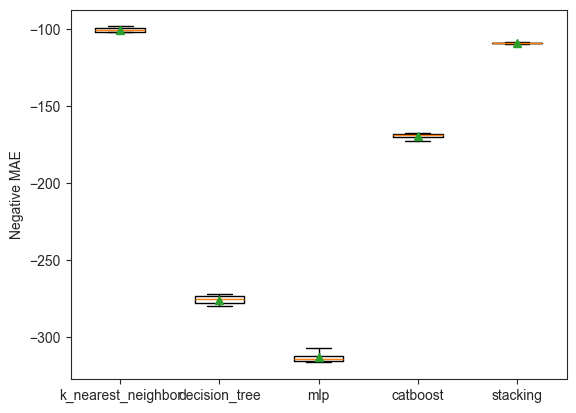

In [65]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X_train, Y_train)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel("Negative MAE")
plt.show()

### Train the stacked model with shuffled data
We can see that the stacking model is better. We will train it on the whole dataset:

In [80]:
# define the base models
level0 = list()
# level0.append(('xgb', XGBRegressor(nthread=2,
#                         device="cpu",
#                         subsample=1.0,
#                         objective ='reg:squarederror',
#                         n_estimators = 600,
#                         min_child_weight=5,
#                         max_depth=6,
#                         gamma=0.1,
#                         eval_metric='rmse',
#                         eta=0.2,
#                         colsample_bytree=0.8,
#                         booster='gbtree'
#                         )))
level0.append(('xgb', XGBRegressor(nthread=2,
                        device="cpu",
                        subsample=1,
                        objective ='reg:squarederror',
                        n_estimators = 1500,
                        min_child_weight=4,
                        max_depth=6,
                        eval_metric='rmse',
                        eta=0.3,
                        colsample_bytree=0.4,
                        booster='gbtree'
                        )))
# level0.append(('catboost', CatBoostRegressor(iterations=1000,
#                         depth=9,
#                         learning_rate=0.35,
#                         l2_leaf_reg=6,
#                         loss_function='RMSE',
#                         verbose=0,
#                         allow_writing_files=False)))
level0.append(('catboost', CatBoostRegressor(iterations=3000,
                          depth=8,
                          learning_rate=0.4,
                          min_data_in_leaf=8,
                          l2_leaf_reg=9,
                          loss_function='RMSE',
                          random_strength=1,
                          verbose=100,
                          allow_writing_files=False)))

level0.append(('decision_tree', DecisionTreeRegressor(splitter='random',
                                                    min_samples_split=3,
                                                    min_samples_leaf=2,
                                                    max_depth=None)))
level0.append(('k_nearest_neighbor', KNeighborsRegressor(n_neighbors=2,
                                                        leaf_size=35,
                                                        algorithm='brute')))


# define meta learner model
level1 = lgb.LGBMRegressor(tree_learner= 'serial',
                           num_threads= 2,
                           num_leaves= 500,
                           n_estimators= 1000,
                           metric= 'mse',
                           learning_rate= 0.08)

# define the stacking ensemble
model = StackingRegressor(estimators=level0,
                          final_estimator=level1,
                          passthrough=True, 
                          cv=10,
                          n_jobs=2,
                          verbose = 1)

# fit the model on all available data
model.fit(X_Train_full[selected_features].astype('float32'), Y_Train_full['pv_measurement'].astype('float32'))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5685
[LightGBM] [Info] Number of data points in the train set: 42360, number of used features: 36
[LightGBM] [Info] Start training from score 186.825520


StackingRegressor(cv=10,
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster='gbtree',
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.4, device='cpu',
                                            early_stopping_rounds=None,
                                            enable_categorical=False, eta=0.3,
                                            eval_metric='rmse',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constrai...
                              ('decision_tree',
                               DecisionTreeRegressor(min_samples_leaf=2,
                                                     min_samples_split=3,
                                                     splitter='random')),
                              ('k_nearest_neighbor',
                               KNeighborsRegressor(algorithm='brute',
                                                   leaf_size=35,
                                                   n_neighbors=2))],
                  final_estimator=LGBMRegressor(learning_rate=0.08,
                                                metric='mse', n_estimators=1000,
                                                num_leaves=500, num_threads=2,
                                                tree_learner='serial'),
                  n_jobs=2, passthrough=True, verbose=1)

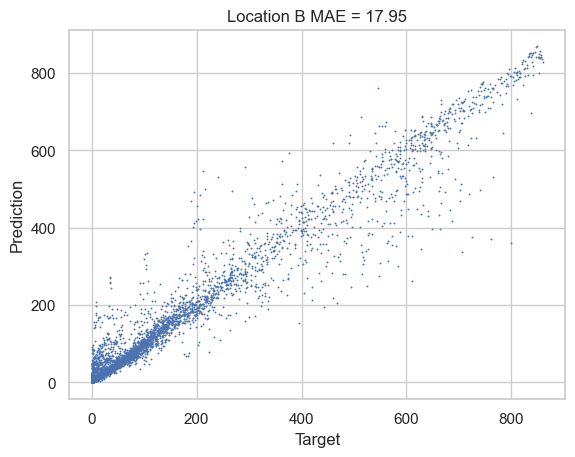

In [62]:
X_test = X_Train_full[selected_features].astype('float32')[11887*4:]
Y_test = Y_Train_full['pv_measurement'].astype('float32')[11887*4:]

Y_pred = model.predict(X_test)
Y_pred[Y_pred<0]=0

mae = mean_absolute_error(Y_test, Y_pred)

plt.figure()
plt.scatter(Y_test,Y_pred,s=0.05,marker="*")
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"Location {LOCATION} MAE = {mae:.2f}")
plt.show()

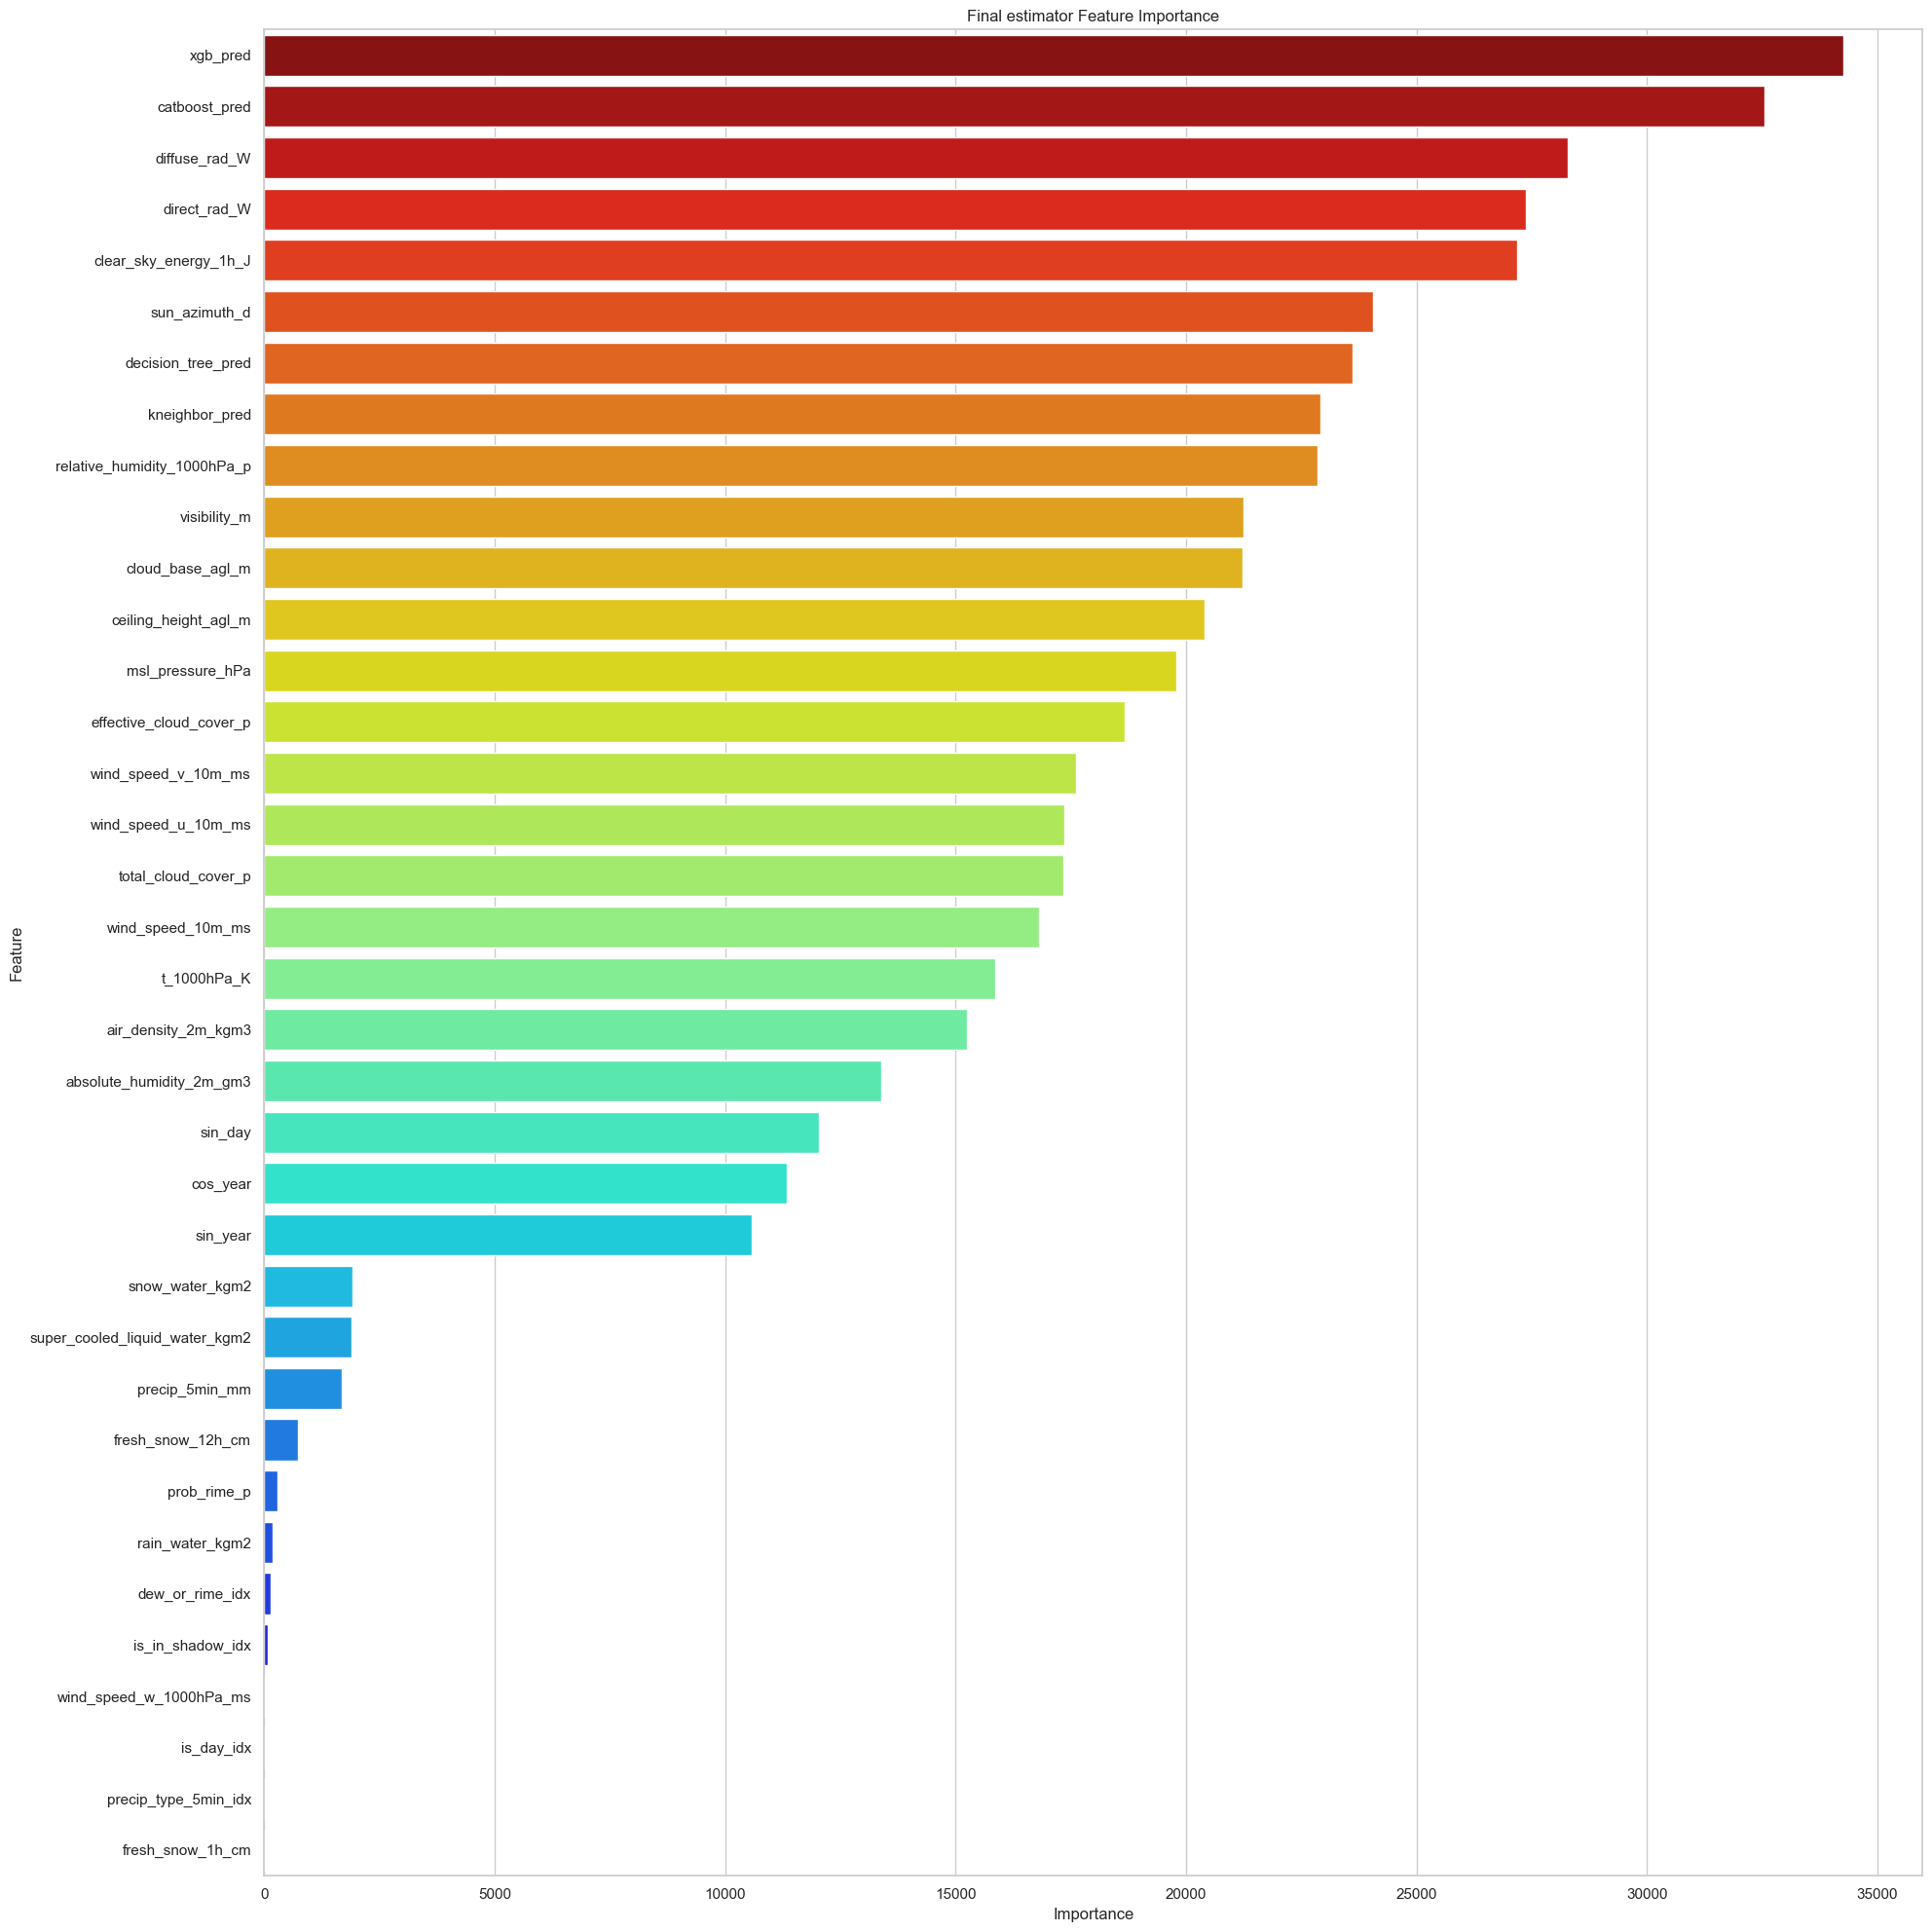

In [81]:
# Create a DataFrame to store feature names and their importances
# importance_df = pd.DataFrame({'Feature': ['xgb_pred','catboost_pred','decision_tree_pred','kneighbor_pred']+selected_features,
#                               'Importance': model.final_estimator_.feature_importances_})
importance_df = pd.DataFrame({'Feature': ['xgb_pred','catboost_pred','decision_tree_pred','kneighbor_pred']+selected_features,
                              'Importance': model.final_estimator_.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Set the style for the plot (optional)
sns.set(style="whitegrid")

# Create a barplot
plt.figure(figsize=(20, 20),dpi=100)
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="jet_r", hue='Feature',width=0.8,gap=2,dodge='auto')

# Customize the plot
plt.title('Final estimator Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

# Show the plot
plt.show()

In [82]:
# Save model
from joblib import dump, load
name = 'xgb_catboost_kneighbor_dectree_to_lgb_lag0_minmax_v1'
dump(model, 'Stacked_models/'+name + LOCATION+'.joblib')

['Stacked_models/xgb_catboost_kneighbor_dectree_to_lgb_lag0_minmax_v1C.joblib']

In [91]:
name = 'catboost_kneighbor_dectree_to_lgb_lag2_minmax_v1'
stacked_model = load('Stacked_models/'+name + LOCATION+'.joblib')
stacked_model

StackingRegressor(cv=10,
                  estimators=[('catboost',
                               <catboost.core.CatBoostRegressor object at 0x000002058208BBB0>),
                              ('decision_tree',
                               DecisionTreeRegressor(min_samples_leaf=2,
                                                     min_samples_split=3,
                                                     splitter='random')),
                              ('k_nearest_neighbor',
                               KNeighborsRegressor(leaf_size=35,
                                                   n_neighbors=2))],
                  final_estimator=LGBMRegressor(learning_rate=0.08,
                                                metric='mse', n_estimators=1000,
                                                num_leaves=500, num_threads=2,
                                                tree_learner='serial'),
                  n_jobs=2, passthrough=True, verbose=1)

### Train the model on estimated data only

In [85]:
# Load pre-trained models (on observed data)
from joblib import dump,load
kneigbor_model = load('KNeighbor_models/kneighbor_'+LOCATION+'_lag2_observed.joblib')
catboost_model = CatBoostRegressor()
catboost_model.load_model("CatBoost_models/CatBoost"+LOCATION+"_lag2_observed_minmax.cbm",format='cbm')

In [86]:
# define the base models
level0 = list()
level0.append(('catboost', catboost_model))
level0.append(('kneighbor', kneigbor_model))


# define meta learner model
level1 = lgb.LGBMRegressor(tree_learner= 'serial',
                           num_threads= 2,
                           num_leaves= 100,
                           n_estimators= 500,
                           metric= 'mse',
                           learning_rate= 0.08)

# define the stacking ensemble
model = StackingRegressor(estimators=level0,
                          final_estimator=level1,
                          passthrough=True, 
                          cv="prefit",
                          n_jobs=2,
                          verbose = 1)

# fit the model on estimated data
model.fit(X_train_est, Y_train_est)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10533
[LightGBM] [Info] Number of data points in the train set: 4388, number of used features: 88
[LightGBM] [Info] Start training from score 100.459982


StackingRegressor(cv='prefit',
                  estimators=[('catboost',
                               <catboost.core.CatBoostRegressor object at 0x00000204800FB1C0>),
                              ('kneighbor',
                               KNeighborsRegressor(algorithm='brute',
                                                   leaf_size=35,
                                                   n_neighbors=20))],
                  final_estimator=LGBMRegressor(learning_rate=0.08,
                                                metric='mse', n_estimators=500,
                                                num_leaves=100, num_threads=2,
                                                tree_learner='serial'),
                  n_jobs=2, passthrough=True, verbose=1)

Location C --estimated-- MAE : 6.12


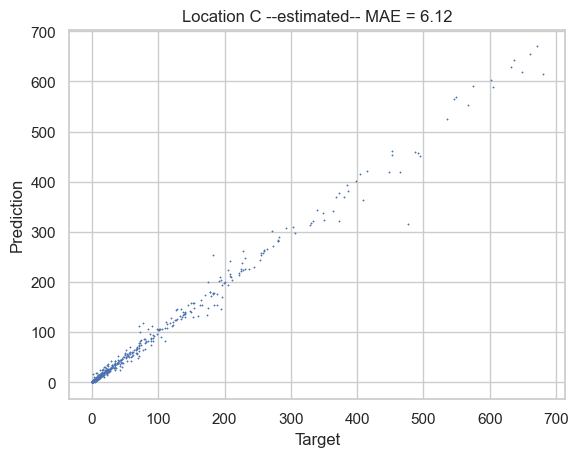

In [87]:
X = X_test_est
Y = Y_test_est

Y_pred = model.predict(X)
Y_pred[Y_pred<0]=0

mae = mean_absolute_error(Y,Y_pred)

print(f"Location {LOCATION} --estimated-- MAE : {mae:.2f}")

plt.figure()
plt.scatter(Y,Y_pred,s=0.05,marker="*")
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"Location {LOCATION} --estimated-- MAE = {mae:.2f}")
plt.show()

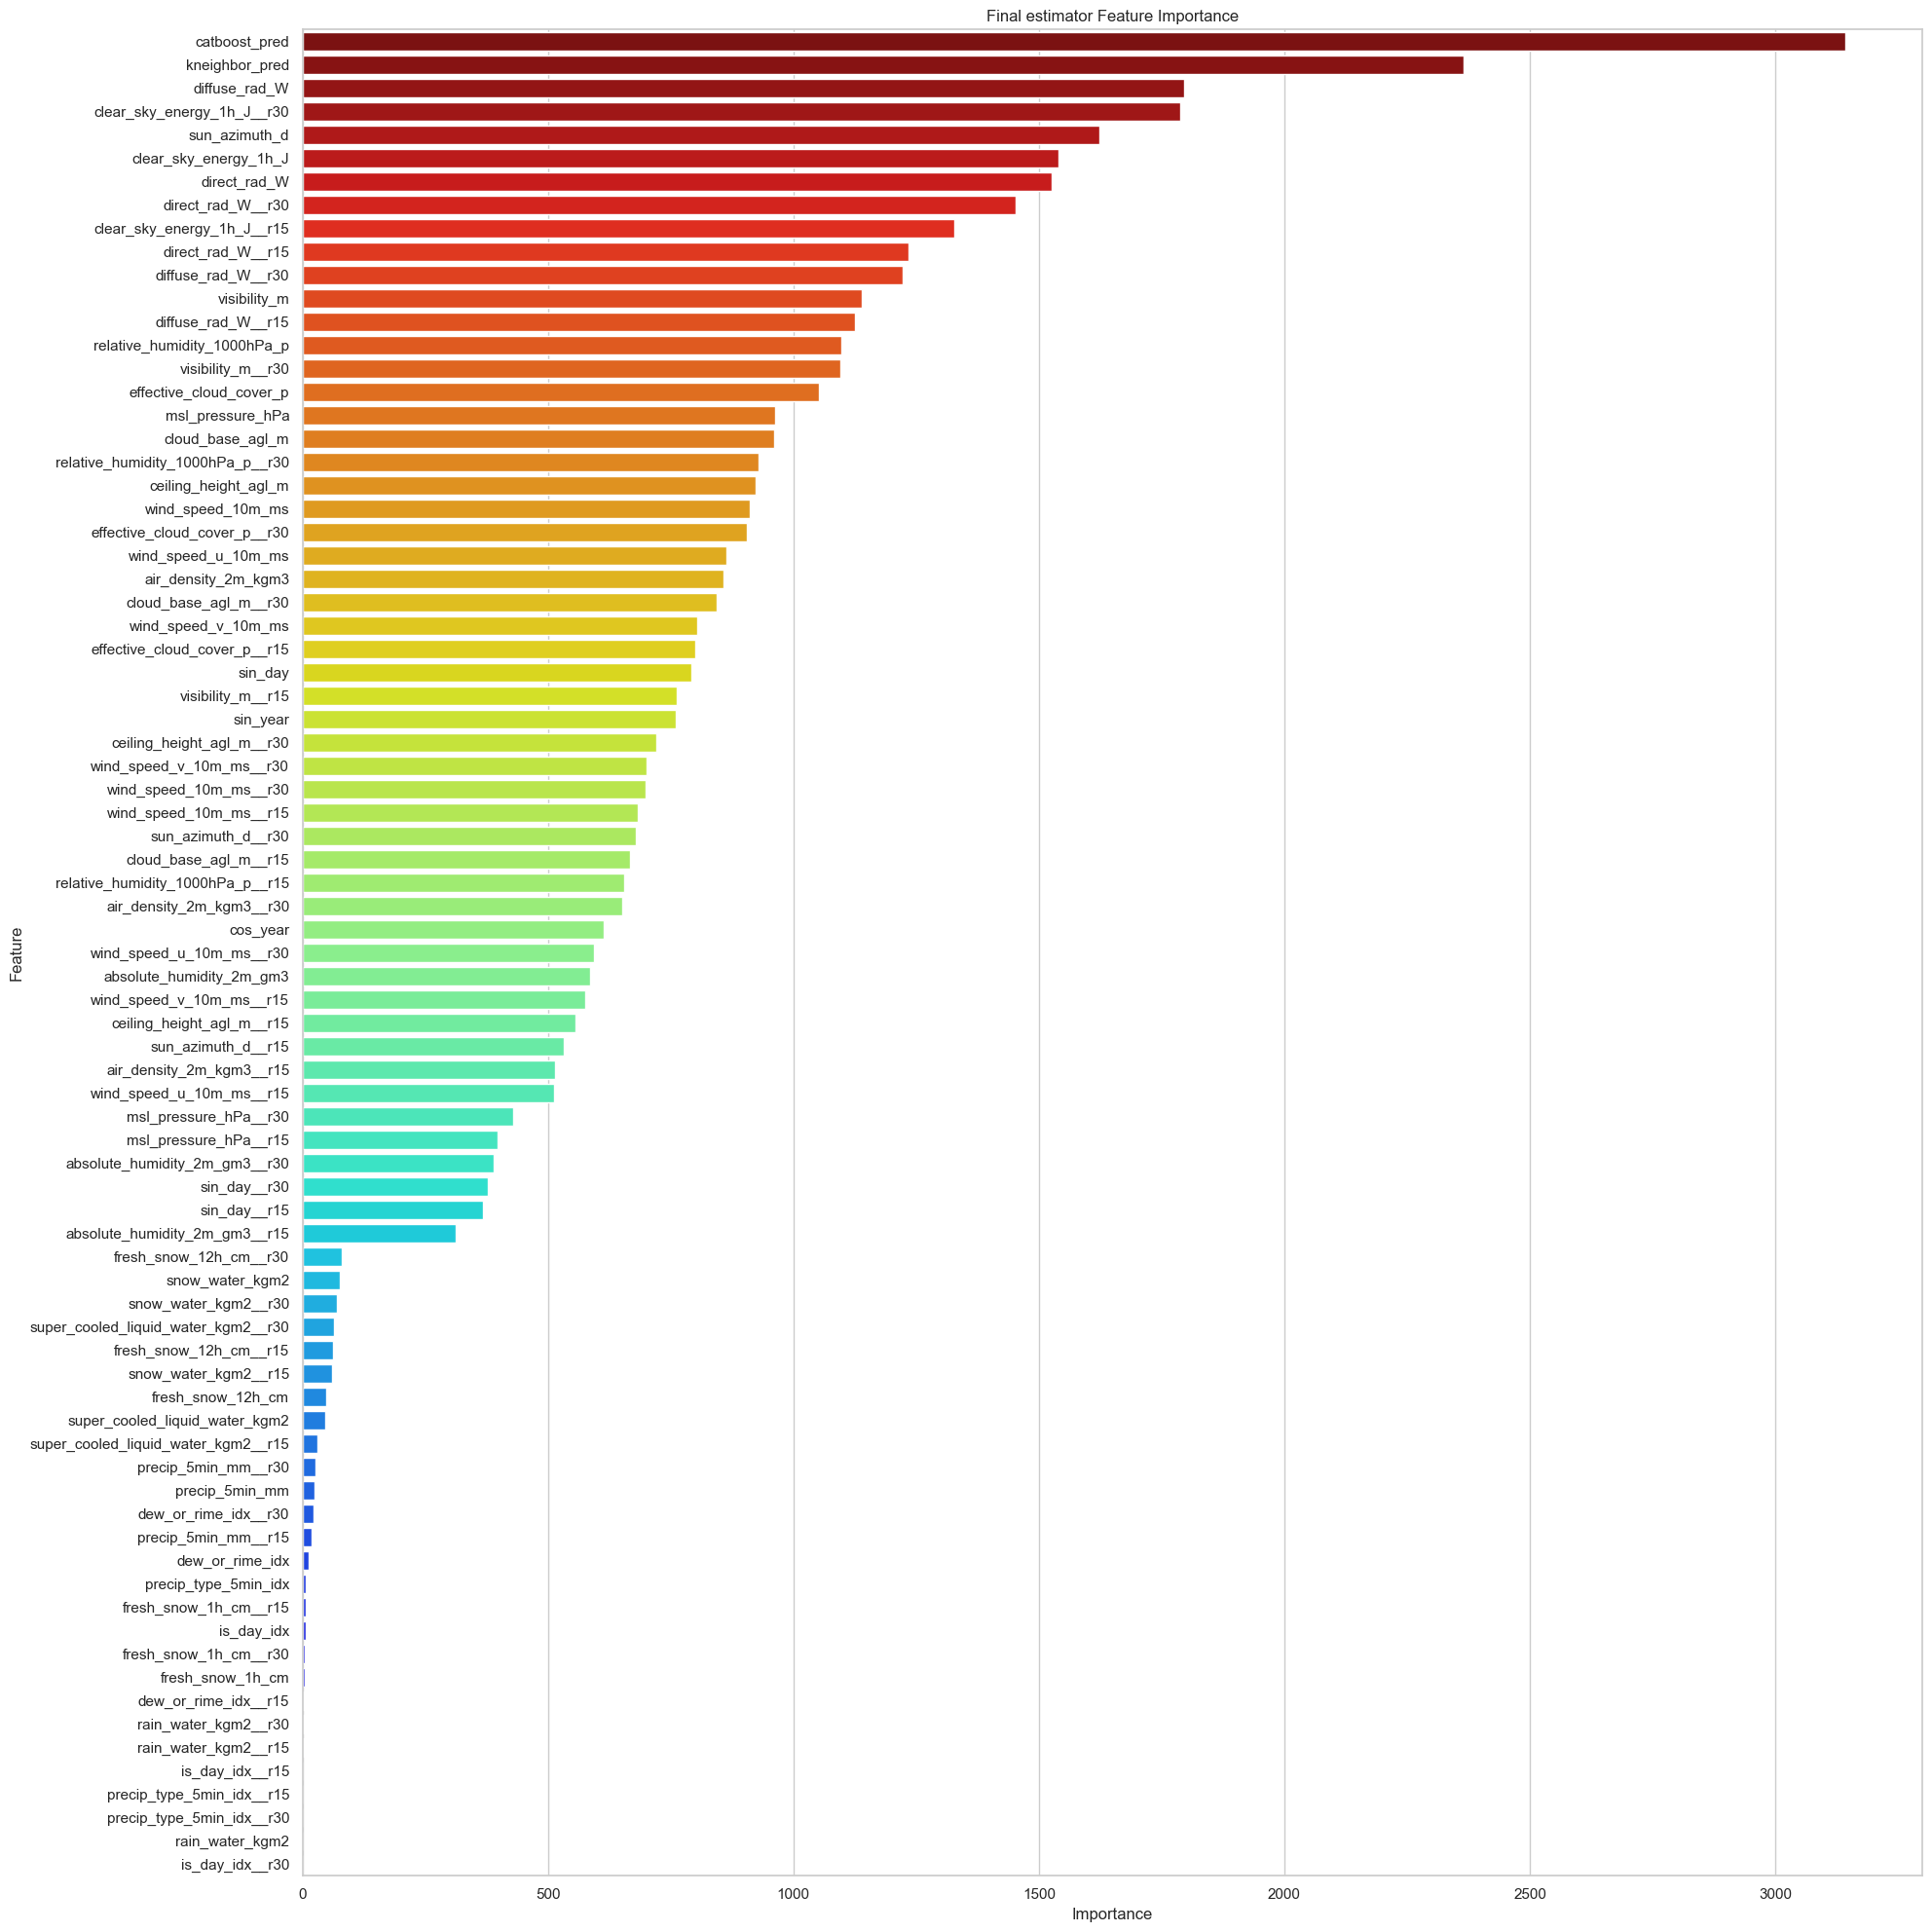

In [60]:
importance_df = pd.DataFrame({'Feature': ['catboost_pred','kneighbor_pred']+selected_features,
                              'Importance': model.final_estimator_.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Set the style for the plot (optional)
sns.set(style="whitegrid")

# Create a barplot
plt.figure(figsize=(20, 20),dpi=100)
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="jet_r", hue='Feature',width=0.8,gap=2,dodge='auto')

# Customize the plot
plt.title('Final estimator Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

# Show the plot
plt.show()

In [88]:
# Train on the whole estimated dataset (unshuffled)
model = StackingRegressor(estimators=level0,
                          final_estimator=level1,
                          passthrough=True, 
                          cv="prefit",
                          n_jobs=2,
                          verbose = 1)

# fit the model on estimated data
model.fit(X_Train_est, Y_Train_est)

dump(model,"Stacked_models/catboostOBS_kneighborOBS_to_lgbEST_lag2_minmax_"+LOCATION+".joblib")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10556
[LightGBM] [Info] Number of data points in the train set: 4876, number of used features: 88
[LightGBM] [Info] Start training from score 99.635618


['Stacked_models/catboostOBS_kneighborOBS_to_lgbEST_lag2_minmax_C.joblib']

### Train the model with time series split (no shuffle)

In [17]:
from sklearn.model_selection import TimeSeriesSplit

# Train_data
X = X_train.reset_index(drop=True)
y = Y_train.reset_index(drop=True)
print(X.shape)

# initialize the models to be stacked (level0)

cb = CatBoostRegressor(iterations=1000,
                       depth=9,
                       learning_rate=0.35,
                       l2_leaf_reg=6,
                       loss_function='RMSE',
                       verbose=0,
                       allow_writing_files=False)

dt = DecisionTreeRegressor(splitter='random',
                           min_samples_split=3,
                           min_samples_leaf=2,
                           max_depth=None)

kn = KNeighborsRegressor(n_neighbors=5,
                         leaf_size=35)


print("TimeSeriesSplit training")
# generate cross-val-prediction with rf and gb using TimeSeriesSplit
cross_val_predict = np.row_stack([
    np.column_stack([
        cb.fit(X.iloc[id_train], y.iloc[id_train]).predict(X.iloc[id_test]), # predictions on the current fold
        dt.fit(X.iloc[id_train], y.iloc[id_train]).predict(X.iloc[id_test]), # predictions on the current fold
        kn.fit(X.iloc[id_train], y.iloc[id_train]).predict(X.iloc[id_test]), # predictions on the current fold
        X.iloc[id_test],     # add the fold test values
        y.iloc[id_test]      # last position is the target fold
    ])
    for id_train,id_test in TimeSeriesSplit(n_splits=20).split(X)
])  # (test_size*n_splits, n_models_to_stack+2)

print("Fitting level0 models on the whole dataset")
# final fit of the level0 models with all the available data
cb.fit(X,y)
dt.fit(X,y)
kn.fit(X,y)

print("Fitting final estimator on previous folds")
# fit a lgb stacking on cross_val_predict+x
stacking = lgb.LGBMRegressor(tree_learner= 'serial',
                             num_threads= 2,
                             num_leaves= 500,
                             n_estimators= 1000,
                             metric= 'mse',
                             learning_rate= 0.08)
stacking.fit(cross_val_predict[:,:-1], cross_val_predict[:,-1])
print('Done')

(70045, 28)
TimeSeriesSplit training
Fitting level0 models on the whole dataset
Fitting final estimator on previous folds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4818
[LightGBM] [Info] Number of data points in the train set: 66700, number of used features: 30
[LightGBM] [Info] Start training from score 1140.807950
Done


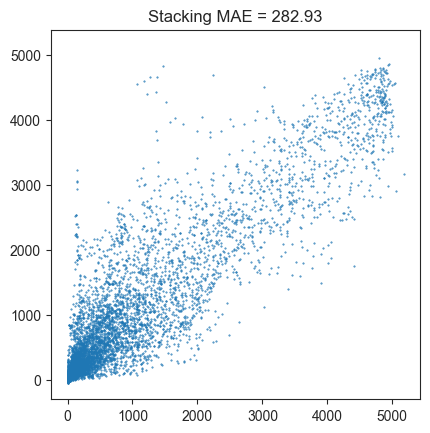

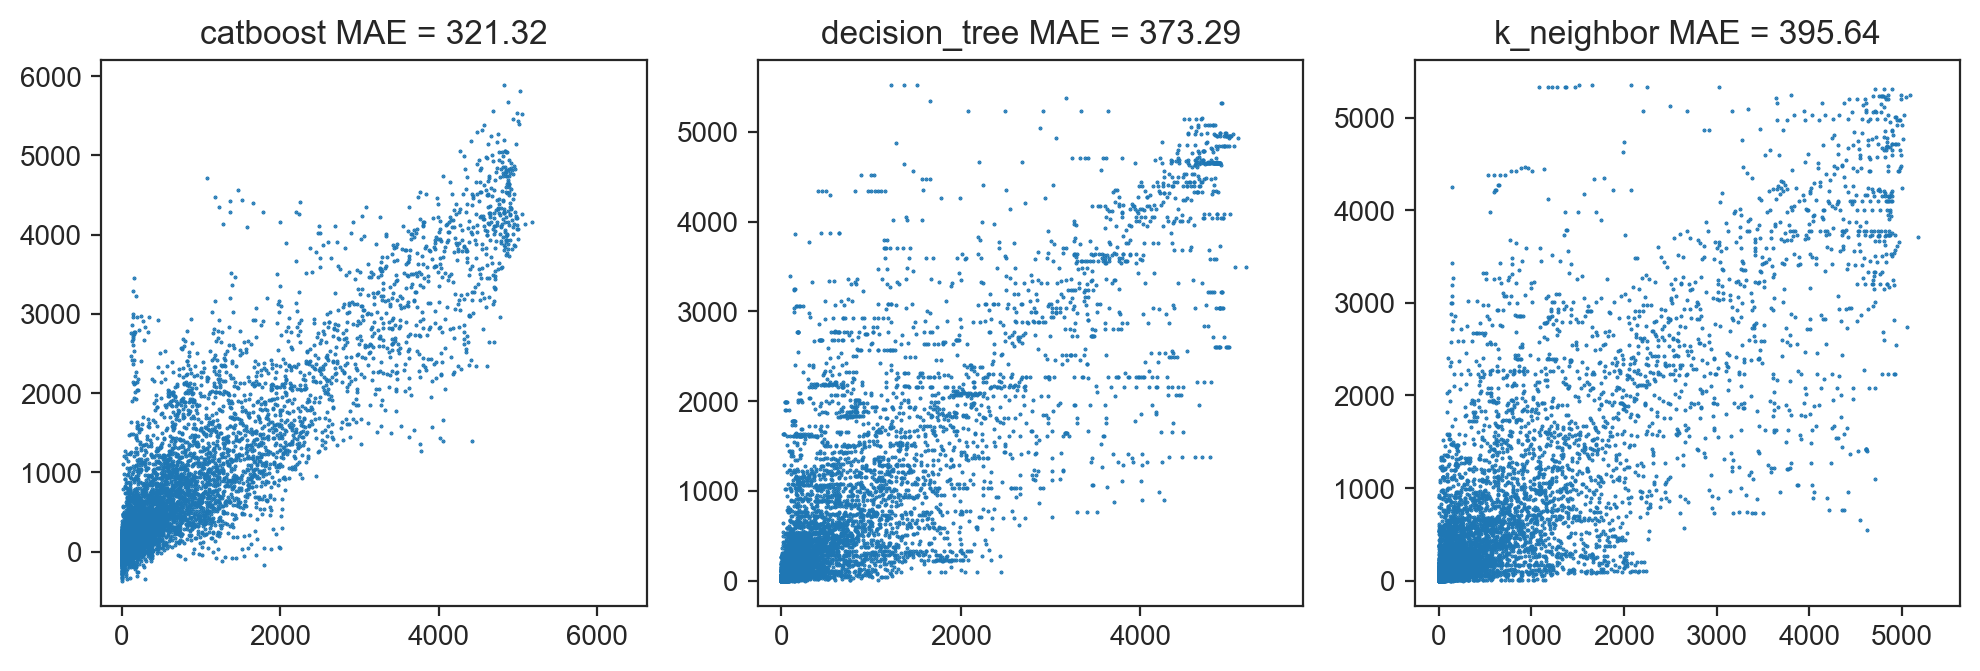

In [18]:
# generate predictions on new unseen data and compare each model
X_new = X_test.reset_index(drop=True)
stack_pred = np.asarray(stacking.predict(
    np.column_stack([
        cb.predict(X_new),
        dt.predict(X_new),
        kn.predict(X_new),
        X_new
    ])
))

stack_mae = mean_absolute_error(stack_pred,Y_test)


plt.figure()
plt.scatter(Y_test,stack_pred,s=0.2)
plt.title(f"Stacking MAE = {stack_mae:.2f}")
plt.axis("square")
plt.show()

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(10,10),dpi=200)
for index,model in enumerate([cb,dt,kn]):
    pred = model.predict(X_new)
    mae = mean_absolute_error(pred,Y_test)
    ax[index].scatter(Y_test,pred,s=0.2)
    ax[index].set_title(["catboost","decision_tree","k_neighbor"][index]+f" MAE = {mae:.2f}")
    ax[index].axis("square")
fig.tight_layout()
plt.show()

---
## Tests

In [20]:
catboost_model = CatBoostRegressor()
catboost_model.load_model("CatBoost_models/CatBoost"+LOCATION+"_lag1_minmax.cbm",format='cbm')

In [41]:
# Prediction on the whole training dataset (dumb)
# Y = MLP_model.predict(X_train_lagged_selected)
# n_features=X_train_lagged_selected.shape[1]
# Y = model.predict((X_train_lagged_selected.to_numpy()).reshape((-1,n_features//4,4)))

Y2 = model.predict(X_Test)
Y2[Y2<0]=0

# mae = mean_absolute_error(Y, Y_Train)

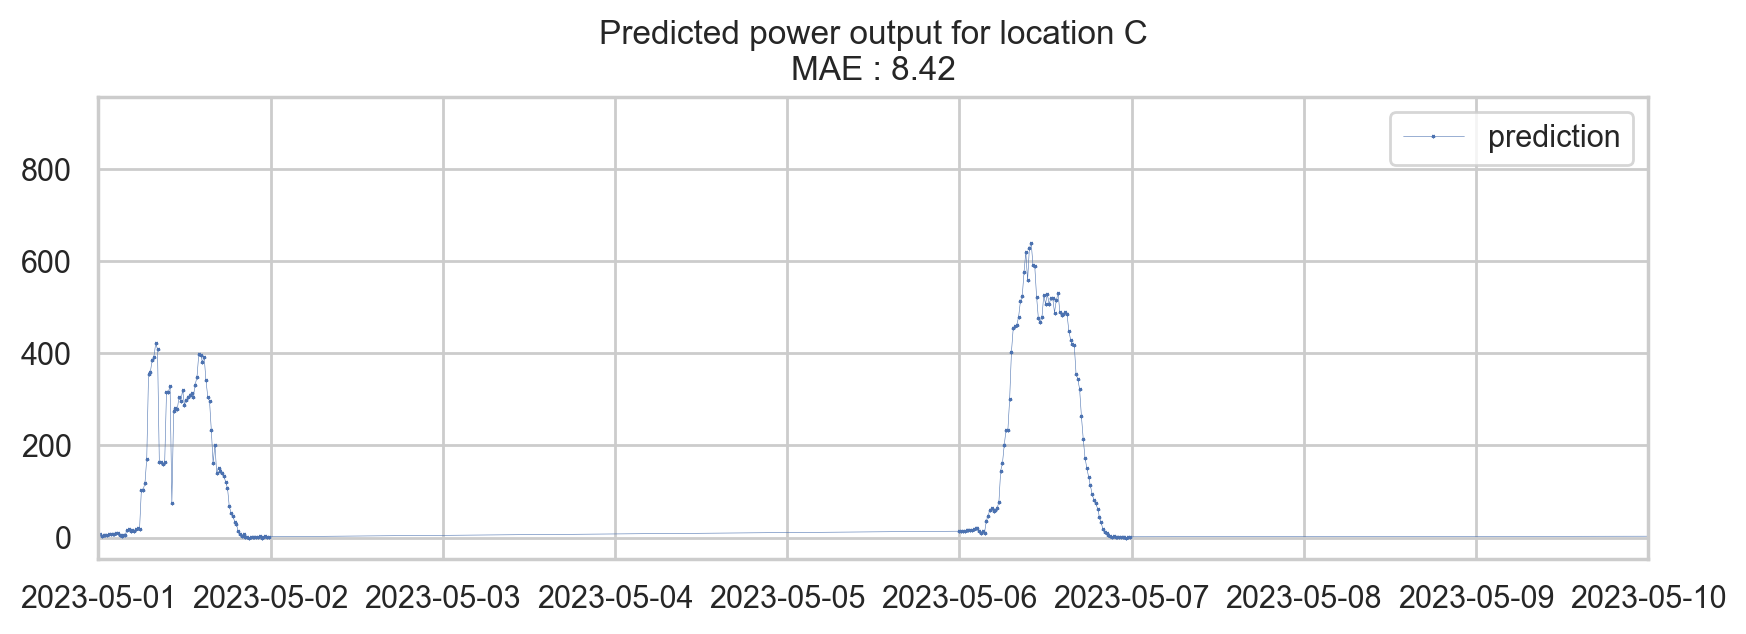

In [44]:
plt.figure(figsize=(10,3),dpi=200)
# plt.plot(X_Test_full['date_forecast'],Y,'-*',linewidth = 0.2, markersize = 0.8, label = 'tasget')
plt.plot(X_Test_full['date_forecast'],Y2, '-*', linewidth = 0.2, markersize = 0.8, label = 'prediction')
plt.title(f"Predicted power output for location {LOCATION}\nMAE : {mae:.2f}")
plt.legend()
plt.xlim([pd.to_datetime('2023-05-01'),pd.to_datetime('2023-05-10')])
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit

# Try with simple data
X = X_train.to_numpy()
y = Y_train.to_numpy()
print(X.shape)

# initialize two models to be stacked (default parameters)
kn = KNeighborsRegressor()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()

print("TimeSeriesSplit training")
# generate cross-val-prediction with rf and gb using TimeSeriesSplit
cross_val_predict = np.row_stack([
    np.column_stack([
        rf.fit(X[id_train], y[id_train]).predict(X[id_test]), # predictions on the current fold
        gb.fit(X[id_train], y[id_train]).predict(X[id_test]), # predictions on the current fold
        kn.fit(X[id_train], y[id_train]).predict(X[id_test]), # predictions on the current fold
        y[id_test]  # we add in the last position the target fold labels
    ])
    for id_train,id_test in TimeSeriesSplit(n_splits=3).split(X)
])  # (test_size*n_splits, n_models_to_stack+1)

print("Fitting level0 models on the whole dataset")
# final fit of the level0 models with all the available data
rf.fit(X,y)
gb.fit(X,y)
kn.fit(X,y)

print("Fitting final estimator on previous folds")
# fit a linear stacking on cross_val_predict
stacking = LinearRegression()
stacking.fit(cross_val_predict[:,:-1], cross_val_predict[:,-1])
print('Done')

In [82]:
# generate predictions on new unseen data and compare each model
X_new = X_test.to_numpy()
stack_pred = stacking.predict(
    np.column_stack([
        rf.predict(X_new),
        gb.predict(X_new),
        kn.predict(X_new)
    ])
)

stack_mae = mean_absolute_error(stack_pred,Y_test)


plt.figure()
plt.scatter(Y_test,stack_pred,s=0.2)
plt.title(f"MAE = {stack_mae:.2f}")
plt.axis("square")
plt.show()

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(10,10),dpi=200)
for index,model in enumerate([rf,gb,kn]):
    pred = model.predict(X_new)
    mae = mean_absolute_error(pred,Y_test)
    ax[index].scatter(Y_test,pred,s=0.2)
    ax[index].set_title(["rf","gb","kn"][index]+f" MAE = {mae:.2f}")
    ax[index].axis("square")
fig.tight_layout()
plt.show()

## Make a prediction for Kaggle

### Catboost

In [119]:
catboost_model = CatBoostRegressor()
catboost_model.load_model("CatBoost_models/CatBoost"+LOCATION+"_lag1_minmax.cbm",format='cbm')

In [120]:
# Predict on the X_test_estimated dataset
Y_test_estimated = pd.DataFrame()
pv_measurement =  catboost_model.predict(X_Test)
pv_measurement[pv_measurement<0]=0
Y_test_estimated['prediction'] = pv_measurement

Y_test_estimated['time'] = X_Test_full['date_forecast']
Y_test_estimated_round = select_o_clock(Y_test_estimated,'time')

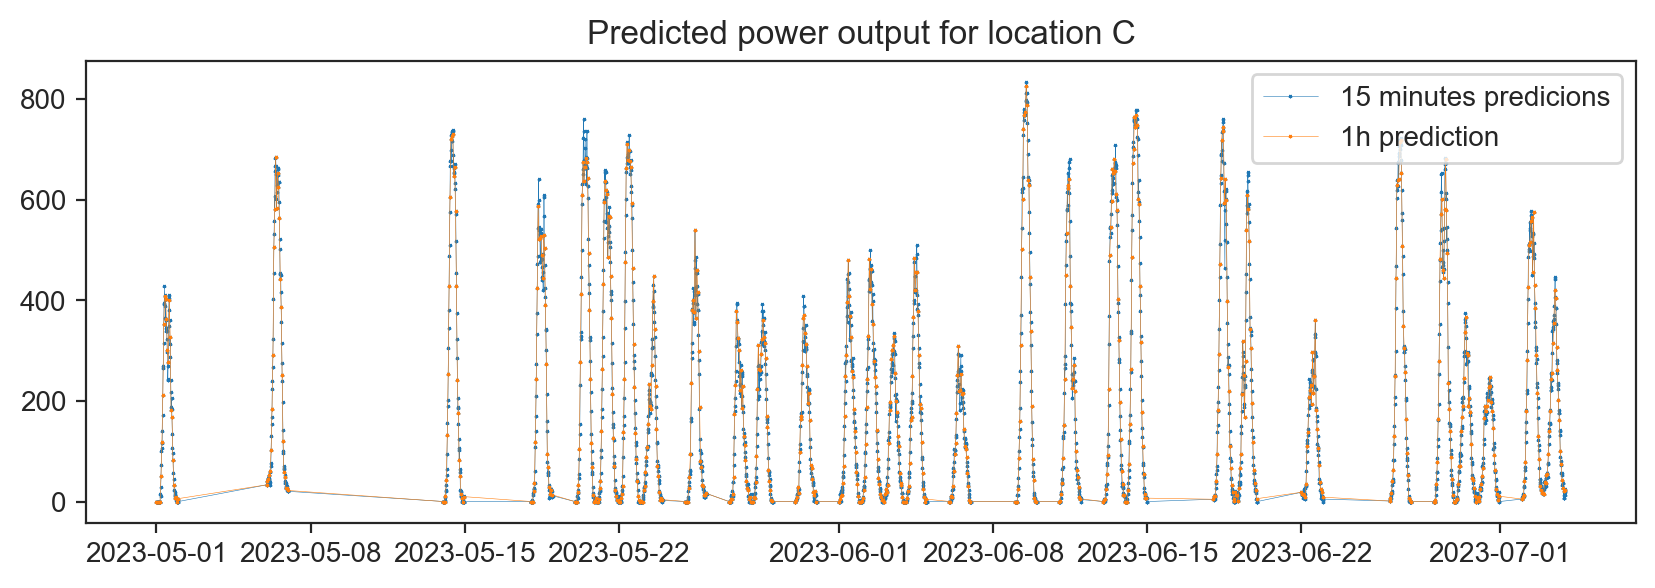

In [121]:
plt.figure(figsize=(10,3),dpi=200)
plt.plot(Y_test_estimated['time'],Y_test_estimated['prediction'],'-*',linewidth = 0.2, markersize = 0.8, label="15 minutes predicions")
plt.plot(Y_test_estimated_round['time'],Y_test_estimated_round['prediction'],'-*',linewidth = 0.2, markersize = 0.8, label="1h prediction")
plt.title(f"Predicted power output for location {LOCATION}")
plt.legend()

plt.show()

In [117]:
# ONLY RUN FOR LOCATION A
PREDICTION_A = Y_test_estimated_round['prediction']

In [112]:
# ONLY RUN FOR LOCATION B
PREDICTION_B = Y_test_estimated_round['prediction']

In [16]:
# ONLY RUN FOR LOCATION C
PREDICTION_C = Y_test_estimated_round['prediction']

NameError: name 'Y_test_estimated_round' is not defined

In [123]:
# Concatenate all 3 predictions
submission = pd.concat([PREDICTION_A, PREDICTION_B, PREDICTION_C]).reset_index()
# Add id colum 
submission['id'] = submission.index
submission

,index,prediction,id
0,0,0.000000,0
1,4,0.000000,1
2,8,16.132665,2
3,12,52.992419,3
4,16,304.694425,4
...,...,...,...
2155,2860,74.134011,2155
2156,2864,42.224285,2156
2157,2868,26.983954,2157
2158,2872,21.465759,2158


In [124]:
# SAVE TO CSV 
name = "catboost_lag1_minmax"
submission.to_csv("Submissions/"+name+".csv",
                  columns=['id','prediction'],
                  index=False,
                  encoding='utf8')

### Joblib-saved model

In [83]:
from joblib import load
name = 'xgb_catboost_kneighbor_dectree_to_lgb_lag0_minmax_v1'
model = load('Stacked_models/'+name + LOCATION +'.joblib')
model

StackingRegressor(cv=10,
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster='gbtree',
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.4, device='cpu',
                                            early_stopping_rounds=None,
                                            enable_categorical=False, eta=0.3,
                                            eval_metric='rmse',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constrai...
                              ('decision_tree',
                               DecisionTreeRegressor(min_samples_leaf=2,
                                                     min_samples_split=3,
                                                     splitter='random')),
                              ('k_nearest_neighbor',
                               KNeighborsRegressor(algorithm='brute',
                                                   leaf_size=35,
                                                   n_neighbors=2))],
                  final_estimator=LGBMRegressor(learning_rate=0.08,
                                                metric='mse', n_estimators=1000,
                                                num_leaves=500, num_threads=2,
                                                tree_learner='serial'),
                  n_jobs=2, passthrough=True, verbose=1)

In [84]:
# Predict on the X_test_estimated dataset
Y_test_estimated = pd.DataFrame()
pv_measurement =  model.predict(X_Test_full[selected_features].astype('float32'))
pv_measurement[pv_measurement<0]=0
Y_test_estimated['prediction'] = pv_measurement

Y_test_estimated['time'] = X_Test_full['date_forecast'].reset_index(drop=True)
Y_test_estimated_round = select_o_clock(Y_test_estimated,'time')


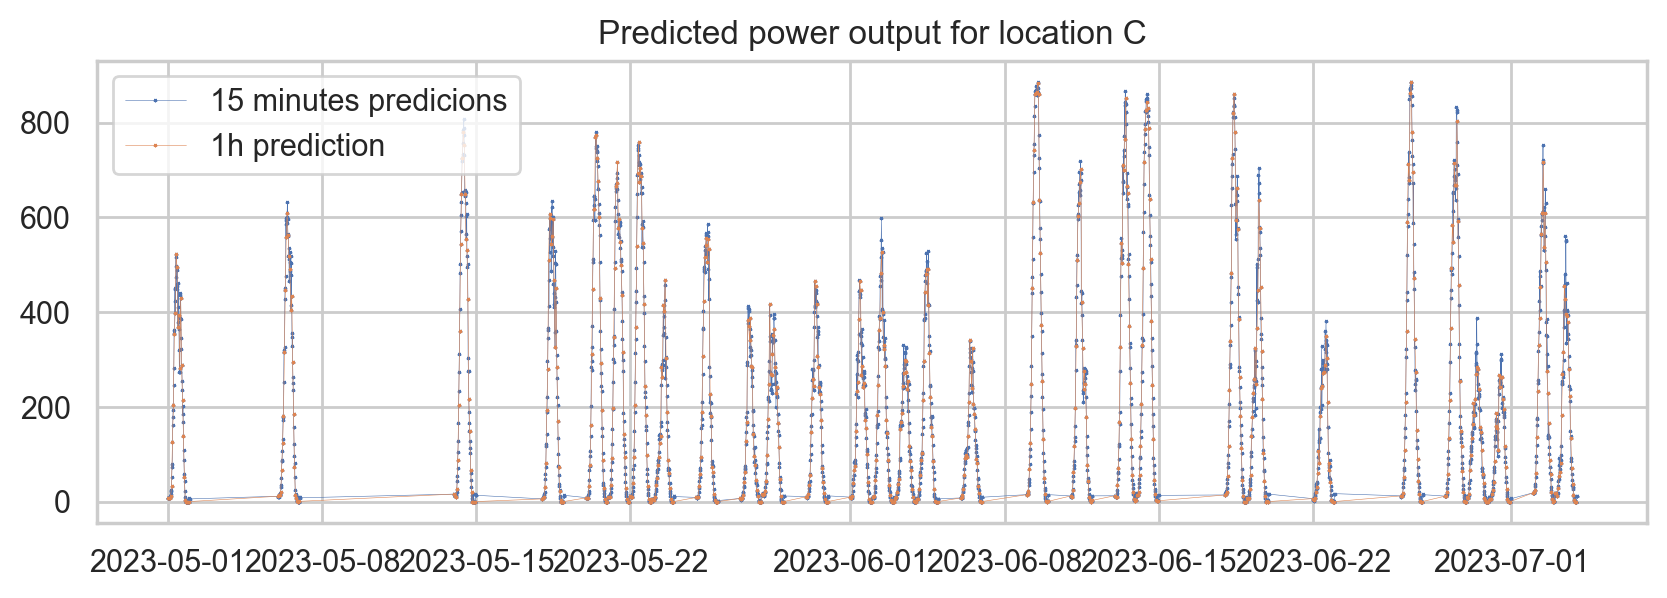

In [85]:
plt.figure(figsize=(10,3),dpi=200)
plt.plot(Y_test_estimated['time'],Y_test_estimated['prediction'],'-*',linewidth = 0.2, markersize = 0.8, label="15 minutes predicions")
plt.plot(Y_test_estimated_round['time'],Y_test_estimated_round['prediction'],'-*',linewidth = 0.2, markersize = 0.8, label="1h prediction")
plt.title(f"Predicted power output for location {LOCATION}")
plt.legend()

plt.show()

In [78]:
# ONLY RUN FOR LOCATION A
PREDICTION_A = Y_test_estimated_round['prediction']

In [73]:
# ONLY RUN FOR LOCATION B
PREDICTION_B = Y_test_estimated_round['prediction']

In [86]:
# ONLY RUN FOR LOCATION C
PREDICTION_C = Y_test_estimated_round['prediction']

In [87]:
# Concatenate all 3 predictions
submission = pd.concat([PREDICTION_A, PREDICTION_B, PREDICTION_C]).reset_index()
# Add id colum 
submission['id'] = submission.index
submission

,index,prediction,id
0,0,0.000000,0
1,4,0.000000,1
2,8,9.681938,2
3,12,52.506944,3
4,16,268.090316,4
...,...,...,...
2155,2860,37.212944,2155
2156,2864,13.779904,2156
2157,2868,2.705051,2157
2158,2872,0.000000,2158


In [88]:
# SAVE TO CSV 
name = "xgb_catboost_dectree_kneighbor_to_lgb_minmax_lag0_NO_round_hours"
submission.to_csv("Submissions/"+name+".csv",
                  columns=['id','prediction'],
                  index=False,
                  encoding='utf8')

### MLP

In [29]:
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

os.environ["CUDA_VISIBLE_DEVICES"]="-1" # Comment this line to use GPU

# Load model
path = "./MLP_models/"+LOCATION+"_v4/"
MLP_model = tf.keras.models.load_model(path)

In [30]:
# Make prediction
X_Test_np = X_Test.to_numpy()

# Make predictions
prediction=pd.DataFrame()
pv_measurement =  MLP_model.predict(X_Test_np).flatten()
pv_measurement[pv_measurement<0]=0
prediction['prediction'] = pv_measurement

# select round hours predictions
prediction['time'] = X_Test_full['date_forecast']
prediction_round = select_o_clock(prediction,'time')

90/90 [==============================] - 1s 4ms/step


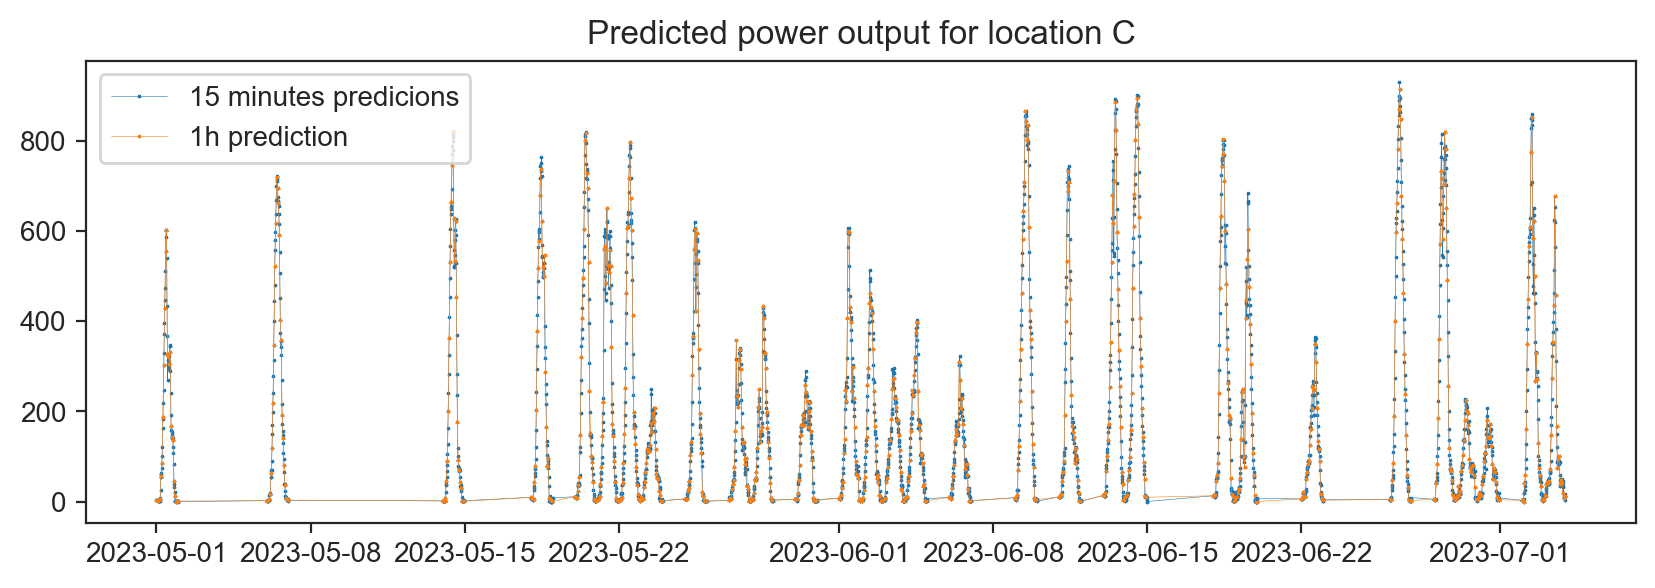

In [31]:
plt.figure(figsize=(10,3),dpi=200)
plt.plot(prediction['time'],prediction['prediction'],'-*',linewidth = 0.2, markersize = 0.8, label="15 minutes predicions")
plt.plot(prediction_round['time'],prediction_round['prediction'],'-*',linewidth = 0.2, markersize = 0.8, label="1h prediction")
plt.title(f"Predicted power output for location {LOCATION}")
plt.legend()
#plt.xlim([pd.to_datetime('2023-05-01'),pd.to_datetime('2023-05-02')])
plt.show()

In [19]:
# ONLY RUN FOR LOCATION A
PREDICTION_A = prediction_round['prediction']

In [25]:
# ONLY RUN FOR LOCATION B
PREDICTION_B = prediction_round['prediction']

In [32]:
# ONLY RUN FOR LOCATION C
PREDICTION_C = prediction_round['prediction']

In [33]:
# Concatenate all 3 predictions
submission = pd.concat([PREDICTION_A, PREDICTION_B, PREDICTION_C]).reset_index()
# Add id colum 
submission['id'] = submission.index
submission

,index,prediction,id
0,0,6.979234,0
1,4,7.392717,1
2,8,12.864594,2
3,12,22.748631,3
4,16,139.383270,4
...,...,...,...
2155,2860,48.244072,2155
2156,2864,40.914688,2156
2157,2868,18.860514,2157
2158,2872,7.297514,2158


In [34]:
# SAVE TO CSV 
name = "submission_MLP_v4_new_loader"
submission.to_csv("Submissions/"+name+".csv",
                  columns=['id','prediction'],
                  index=False,
                  encoding='utf8')

### Compare

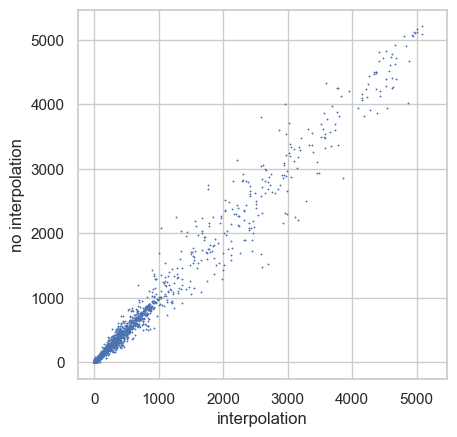

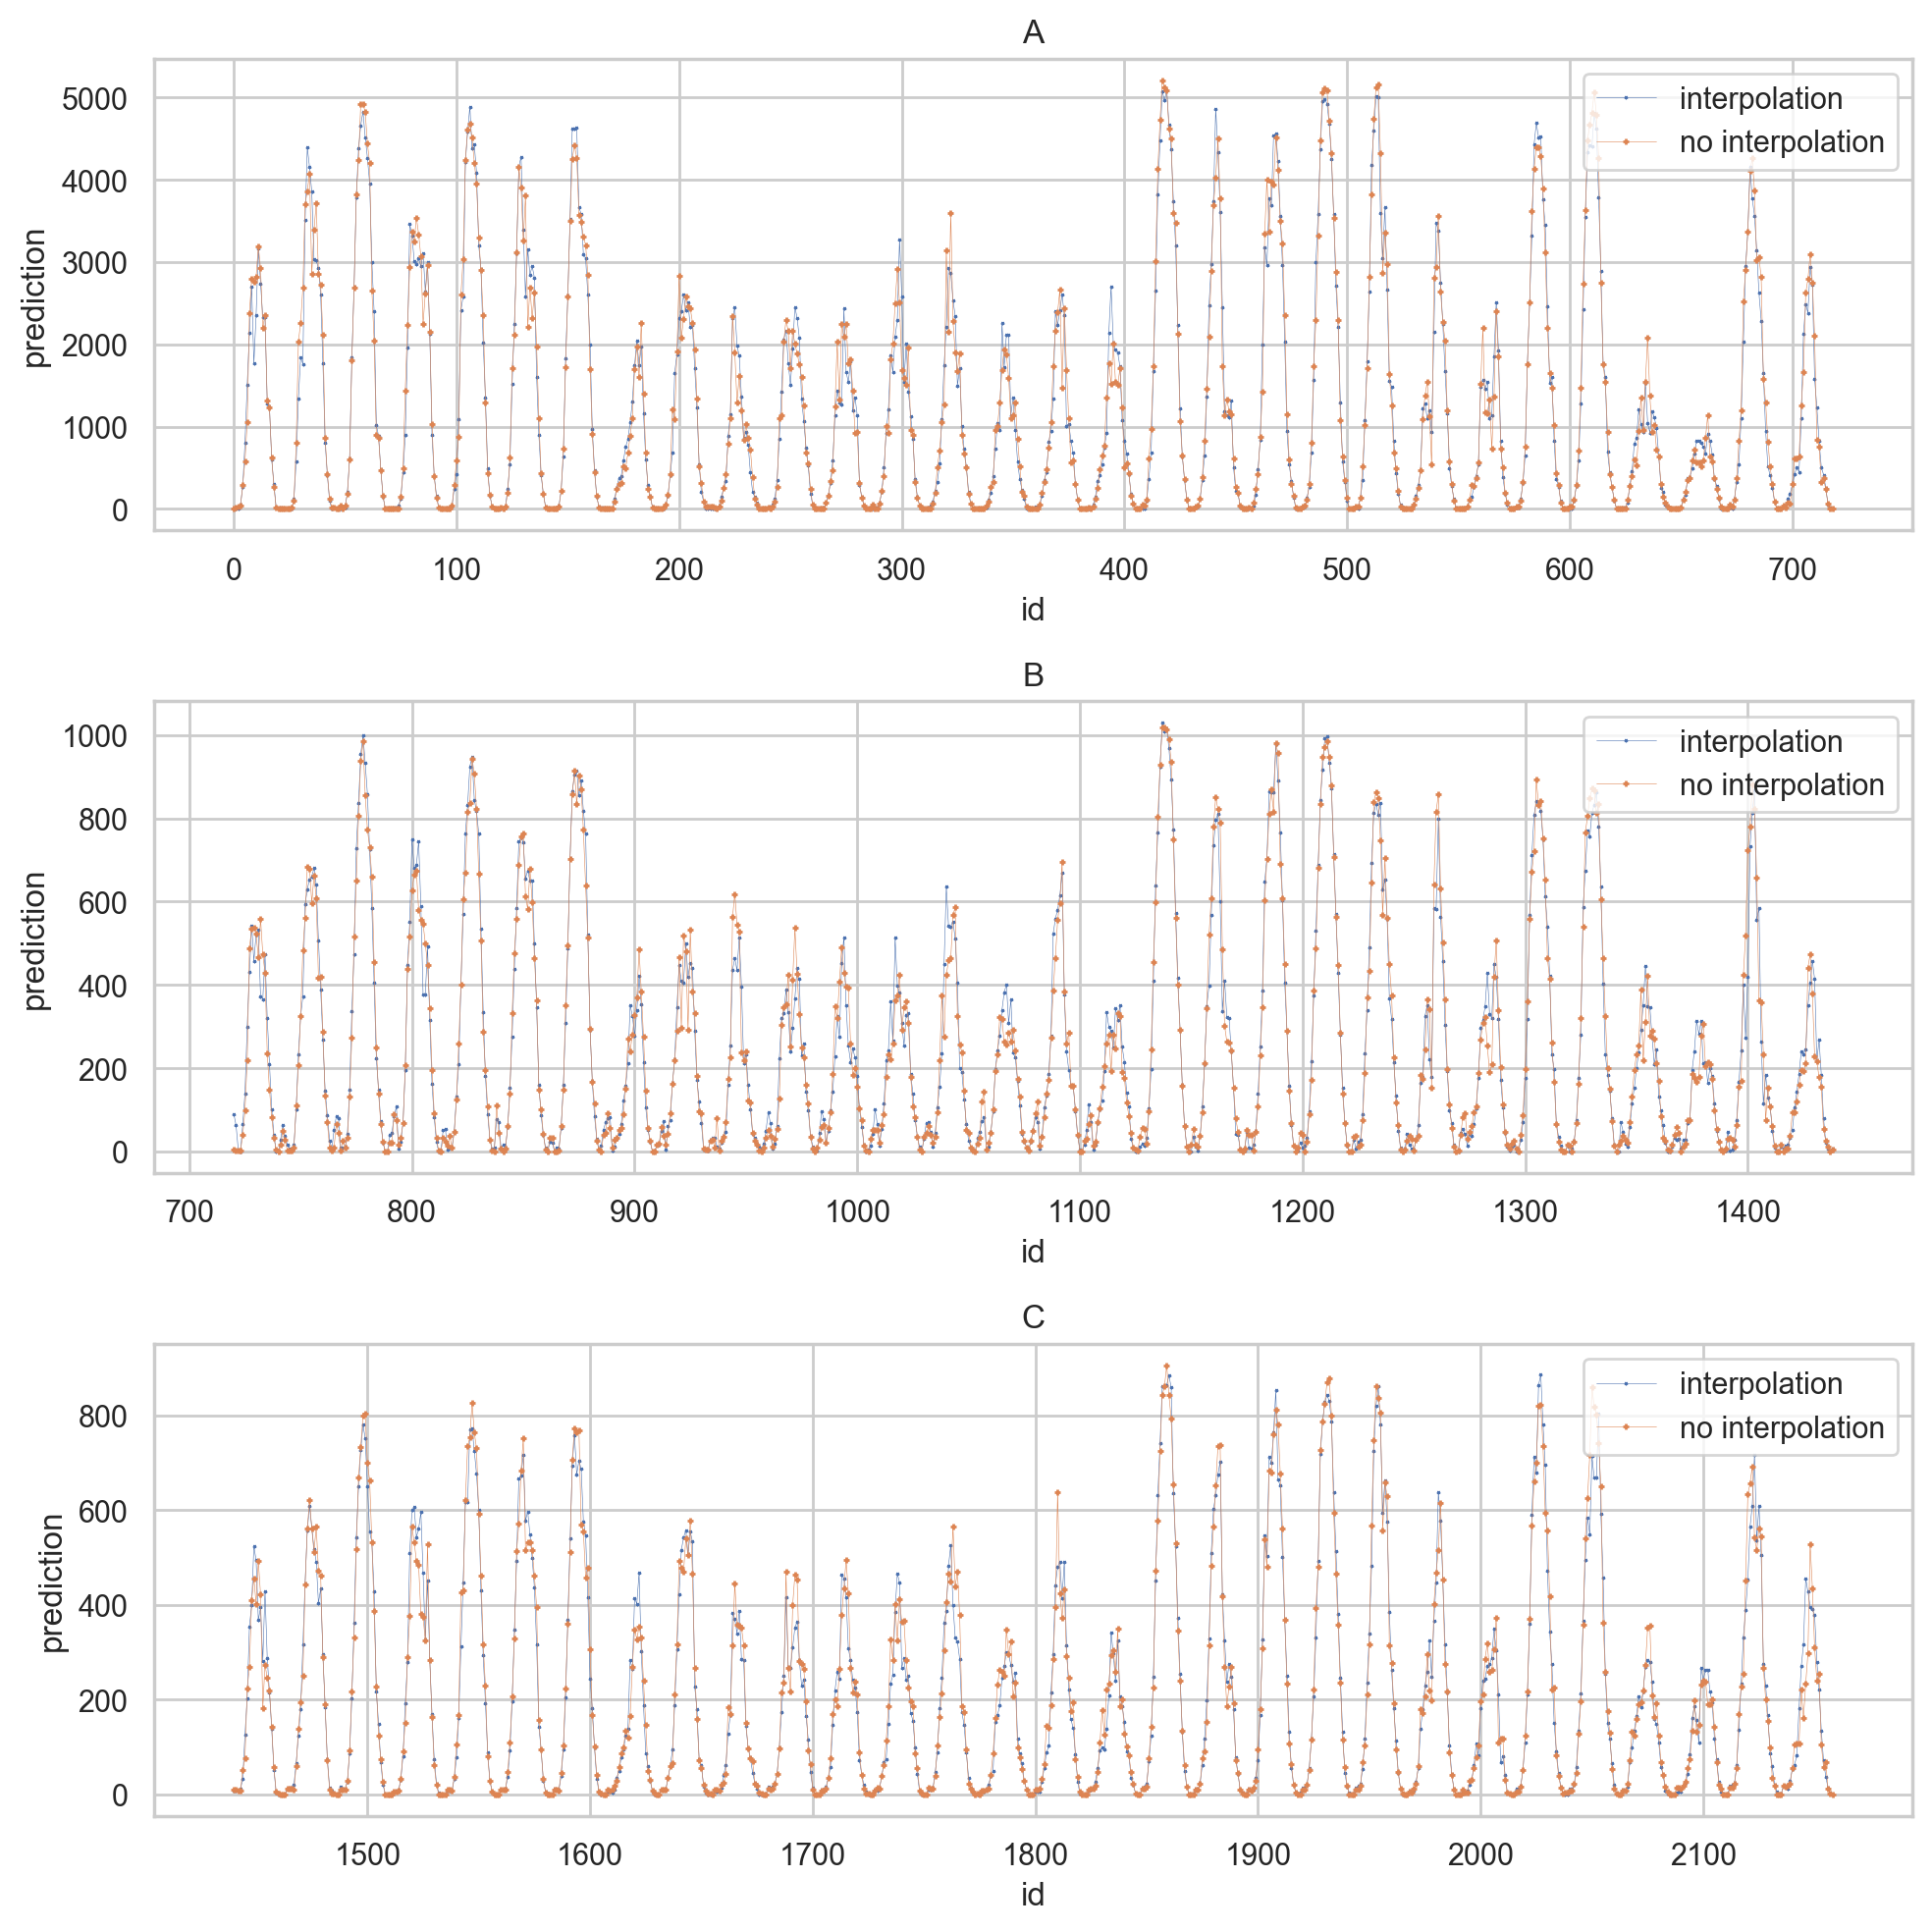

In [90]:
# Compare with previous solutions
# sub1 = pd.read_csv('Submissions/catboost_kneighbor_dectree_to_lgb_lag2_minmax_v1.csv')
sub1 = pd.read_csv('Submissions/xgb_catboost_dectree_kneighbor_to_lgb_minmax_lag0_NO_round_hours.csv')
sub2 = pd.read_csv('Submissions/xgb_catboost_dectree_kneighbor_to_lgb_minmax_lag0_round_hours.csv')
name1 = "interpolation"
name2 = "no interpolation"

# x=np.arange(0,len(PREDICTION_A))
plt.figure()
plt.scatter(sub1['prediction'],sub2['prediction'],s=0.05,marker="*")
plt.xlabel(name1)
plt.ylabel(name2)
# plt.xscale("log")
# plt.yscale("log")
plt.axis("square")
plt.show()

n=sub1.shape[0]//3
fig,ax = plt.subplots(nrows=3,ncols=1,figsize=(10,10),dpi=200)
for index,loc in enumerate(['A','B','C']):
    ax[index].plot(sub1['id'].iloc[index*n:(index+1)*n-1],sub1['prediction'].iloc[index*n:(index+1)*n-1],'-*',linewidth = 0.2, markersize = 0.8, label = name1)
    ax[index].plot(sub2['id'].iloc[index*n:(index+1)*n-1],sub2['prediction'].iloc[index*n:(index+1)*n-1],'-+',linewidth = 0.2, markersize = 2, label = name2)
    ax[index].set_xlabel("id")
    ax[index].set_ylabel("prediction")
    ax[index].set_title(loc)
    ax[index].legend()
fig.tight_layout()
plt.show()
